# Circuit Performance Over Training - All Pythia Scales

In [1]:
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the HookedTransformer code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")

/tmp/ipykernel_474/4115428919.py:5: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_474/4115428919.py:6: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [2]:
import os
import torch
import pandas as pd
import plotly.express as px
import transformer_lens.utils as utils

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [3]:
torch.set_grad_enabled(False)

In [4]:
# =============================================================================
#pio.renderers.default = 'png' # USE IF MAKING GRAPHS FOR NOTEBOOK EXPORT
# =============================================================================

In [5]:
from neel_plotly import line, imshow, scatter

def l_imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def l_line(tensor, renderer=None, width=1200, height=500, **kwargs):
    fig = px.line(y=utils.to_numpy(tensor), **kwargs)
    fig.update_layout(
        autosize=False,
        width=width,
        height=height
    )
    fig.show(renderer=renderer)

def l_scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

def two_lines(tensor1, tensor2, renderer=None, **kwargs):
    px.line(y=[utils.to_numpy(tensor1), utils.to_numpy(tensor2)], **kwargs).show(renderer)

In [6]:
def get_checkpoint_names(mode: str = "linear"):
    if mode == "linear":
        ckpts = [i * 1000 for i in range(1, 144)]
    elif mode == "exponential":
        ckpts = [
            round((2**i) / 1000) * 1000 if 2**i > 1000 else 2**i
            for i in range(18)
        ]
    elif mode == "exp_plus_detail":
        ckpts = (
            [2**i for i in range(10)]
            + [i * 1000 for i in range(1, 16)]
            + [i * 5000 for i in range(4, 14)]
            + [i * 10000 for i in range(7, 15)]
            + [143000]
        )
    else:
        ckpts = [1, 2]

    return ckpts

In [7]:
def plot_lines(data_series, labels, colors, x_vals, x_title='X', y_title='Y', title='Line plot'):
    fig = go.Figure()

    for series, label, color in zip(data_series, labels, colors):
        fig.add_trace(go.Scatter(x=x_vals, y=series, mode='lines', name=label, line=dict(color=color)))

    fig.update_xaxes(type='log', title=x_title)
    fig.update_yaxes(title=y_title)
    fig.update_layout(title=title, width=1200, height=500)

    fig.show()

In [14]:
def rescale_tensor(tensor):
    """
    Rescales a tensor with values usually between 0.5 and 1 to be between 0 and 1.

    Args:
        tensor (torch.Tensor): The tensor to be rescaled.

    Returns:
        torch.Tensor: The rescaled tensor.
    """
    # Find the minimum and maximum values in the tensor
    min_val = tensor.min()
    max_val = tensor.max()

    # Normalize the tensor to a range of 0 to 1
    if max_val - min_val > 0:
        rescaled_tensor = (tensor - min_val) / (max_val - min_val)
    else:
        # Handle the case where all values in the tensor are the same
        rescaled_tensor = torch.zeros_like(tensor)

    return rescaled_tensor

In [8]:
def load_metrics(directory):
    nested_dict = {}

    # Iterate through each model subfolder, excluding '.ipynb_checkpoints'
    for model_folder in os.listdir(directory):
        model_path = os.path.join(directory, model_folder)
        if os.path.isdir(model_path) and model_folder != '.ipynb_checkpoints':
            # Create root-level key by dropping the last two words ("no-dropout")
            model_key = '-'.join(model_folder.split('-')[:-2])
            nested_dict[model_key] = {}

            # Iterate through each task subfolder
            for task_folder in os.listdir(model_path):
                task_path = os.path.join(model_path, task_folder)
                if os.path.isdir(task_path) and task_folder != '.ipynb_checkpoints':
                    nested_dict[model_key][task_folder] = {}

                    # Load .pt files and add to the dictionary
                    for file in os.listdir(task_path):
                        if file.endswith('.pt'):
                            file_path = os.path.join(task_path, file)
                            tensor = torch.Tensor(torch.load(file_path))
                            nested_dict[model_key][task_folder][file[:-3]] = tensor

    return nested_dict



## Setup

In [9]:
directory_path = 'results'
metrics = load_metrics(directory_path)

ST_DEV_SAMPLE_IDX = -10 # Index of the earliest sample to use for standard deviation calculation
ckpts = get_checkpoint_names(mode="exp_plus_detail")

In [39]:
metrics.keys()

dict_keys(['pythia-70m', 'pythia-160m-data-seed1', 'pythia-160m-weight-seed1', 'pythia-14m', 'pythia-160m-seed3', 'pythia-160m-data-seed3', 'pythia-410m', 'pythia-1.4b', 'pythia-6.9b', 'pythia-160m', 'pythia-160m-weight-seed2', 'pythia-31m', 'pythia-160m-data-seed2', '', 'pythia-160m-seed2', 'pythia-160m-seed1', 'pythia-2.8b', 'pythia-160m-weight-seed3'])

## Metric Performance Over Training by Scale

In [11]:
metrics['pythia-160m']['ioi'].keys()

dict_keys(['rank_0', 'probability_diff', 'accuracy', 'probability_mass', 'logit_diff'])

### Pythia 70M

In [71]:
metrics['pythia-70m']['ioi']['normed_logit_diff'] = metrics['pythia-70m']['ioi']['logit_diff'] / metrics['pythia-70m']['ioi']['logit_diff'].max()

metrics['pythia-70m']['ioi']['normed_accuracy'] = (metrics['pythia-70m']['ioi']['accuracy'] - 0.5) / (metrics['pythia-70m']['ioi']['accuracy'].max() - metrics['pythia-70m']['ioi']['accuracy'].min())

ckpts = get_checkpoint_names("exp_plus_detail")

In [72]:
len(ckpts)

43

In [73]:
data_series = [
    metrics['pythia-70m']['ioi']['normed_logit_diff'],
    metrics['pythia-70m']['ioi']['normed_accuracy'],
    metrics['pythia-70m']['ioi']['rank_0'],
    metrics['pythia-70m']['ioi']['probability_mass'],
    metrics['pythia-70m']['ioi']['probability_diff']
]




labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='IOI Metrics in 70M Model Over Training Time (Log Scale)')

In [13]:
l_line(metrics['pythia-70m']['ioi']['logit_diff'], title="Pythia-70M IOI Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [14]:
l_line(metrics['pythia-70m']['ioi']['accuracy'], title="Pythia-70M Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [15]:
l_line(metrics['pythia-70m']['ioi']['rank_0'], title="Pythia-70M Correct Rank 0 Rate Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [16]:
l_line(metrics['pythia-70m']['ioi']['probability_mass'], title="Pythia-70M Probability Mass Over Training Time (Log Scale)", x=ckpts, log_x=True)

### Pythia 160M

#### IOI

In [113]:
metrics['pythia-160m']['ioi']['normed_logit_diff'] = metrics['pythia-160m']['ioi']['logit_diff'] / metrics['pythia-160m']['ioi']['logit_diff'].max()

metrics['pythia-160m']['ioi']['normed_accuracy'] = (metrics['pythia-160m']['ioi']['accuracy'] - 0.5) / (metrics['pythia-160m']['ioi']['accuracy'].max() - metrics['pythia-160m']['ioi']['accuracy'].min())

ckpts = get_checkpoint_names("exp_plus_detail")

In [114]:
data_series = [
    metrics['pythia-160m']['ioi']['normed_logit_diff'],
    metrics['pythia-160m']['ioi']['normed_accuracy'],
    metrics['pythia-160m']['ioi']['rank_0'],
    metrics['pythia-160m']['ioi']['probability_mass'],
    metrics['pythia-160m']['ioi']['probability_diff']

]


labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='IOI Metrics in 160M Model Over Training Time (Log Scale)')

In [115]:
l_line(metrics['pythia-160m']['ioi']['logit_diff'], title="Pythia-160M IOI Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [116]:
l_line(metrics['pythia-160m']['ioi']['accuracy'], title="Pythia-160M Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [117]:
l_line(metrics['pythia-160m']['ioi']['rank_0'], title="Pythia-160M Correct Rank 0 Rate Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [118]:
l_line(metrics['pythia-160m']['ioi']['probability_mass'], title="Pythia-160M Probability Mass Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [119]:
metrics['pythia-160m']['ioi']['probability_mass'][15]

tensor(0.1107)

In [120]:
l_line(metrics['pythia-160m']['ioi']['probability_diff'], title="Pythia-160M Probability Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Greater-Than

In [121]:

metrics['pythia-160m']['greater_than']['normed_logit_diff'] = metrics['pythia-160m']['greater_than']['logit_diff'] / metrics['pythia-160m']['greater_than']['logit_diff'].max()
ckpts = get_checkpoint_names("exp_plus_detail")

In [122]:
data_series = [
    metrics['pythia-160m']['greater_than']['normed_logit_diff'],
    metrics['pythia-160m']['greater_than']['prob_diff'],
]
labels = ['Normed Logit Diff', 'Probability Diff']#, 'Probability Mass', ]
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Greater-Than Metrics in 160M Model Over Training Time (Log Scale)')

In [123]:
l_line(metrics['pythia-160m']['greater_than']['logit_diff'], title="Pythia-160M Greater-Than Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Completion

In [124]:
metrics['pythia-160m']['sentiment_cont']['normed_logit_diff'] = metrics['pythia-160m']['sentiment_cont']['logit_diff'] / metrics['pythia-160m']['sentiment_cont']['logit_diff'].max()

metrics['pythia-160m']['sentiment_cont']['normed_accuracy'] = (metrics['pythia-160m']['sentiment_cont']['accuracy'] - 0.5) / (metrics['pythia-160m']['sentiment_cont']['accuracy'].max() - metrics['pythia-160m']['sentiment_cont']['accuracy'].min())
ckpts = get_checkpoint_names("exp_plus_detail")

In [125]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-160m']['sentiment_cont']['normed_accuracy'],
    metrics['pythia-160m']['sentiment_cont']['rank_0'],
    metrics['pythia-160m']['sentiment_cont']['probability_mass'],
    metrics['pythia-160m']['sentiment_cont']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Cont Metrics in 160M Model Over Training Time (Log Scale)')

In [126]:
l_line(metrics['pythia-160m']['sentiment_cont']['logit_diff'], title="Pythia-160M Simple Sentiment Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [127]:
l_line(metrics['pythia-160m']['sentiment_cont']['accuracy'], title="Pythia-160M Simple Sentiment Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Classification

In [128]:
metrics['pythia-160m']['sentiment_class']['normed_logit_diff'] = metrics['pythia-160m']['sentiment_class']['logit_diff'] / metrics['pythia-160m']['sentiment_class']['logit_diff'].max()

metrics['pythia-160m']['sentiment_class']['normed_accuracy'] = (metrics['pythia-160m']['sentiment_class']['accuracy'] - 0.5) / (metrics['pythia-160m']['sentiment_class']['accuracy'].max() - metrics['pythia-160m']['sentiment_class']['accuracy'].min())
ckpts = get_checkpoint_names("exp_plus_detail")

In [129]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['normed_logit_diff'],
    metrics['pythia-160m']['sentiment_class']['normed_accuracy'],
    metrics['pythia-160m']['sentiment_class']['rank_0'],
    metrics['pythia-160m']['sentiment_class']['probability_mass'],
    metrics['pythia-160m']['sentiment_class']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Classification Metrics in 160M Model Over Training Time (Log Scale)')

In [130]:
l_line(metrics['pythia-160m']['sentiment_class']['logit_diff'], title="Pythia-160M Sentiment Classification Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [131]:
l_line(metrics['pythia-160m']['sentiment_class']['accuracy'], title="Pythia-160M Sentiment Classification Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### All Tasks

In [132]:
data_series = [
    metrics['pythia-160m']['ioi']['normed_logit_diff'],
    metrics['pythia-160m']['greater_than']['normed_logit_diff'],
    metrics['pythia-160m']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-160m']['sentiment_class']['normed_logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Normalized Task Logit Diff in 160M Model Over Training Time (Log Scale)')

In [133]:
for m in data_series:
    print(m.shape)

torch.Size([44])
torch.Size([44])
torch.Size([44])
torch.Size([44])


In [134]:
results_dir = f"results/temp_results"
os.makedirs(results_dir, exist_ok=True)
torch.save(metrics, os.path.join(results_dir, f"temp_res.pt"))


In [107]:
data_series = [
    metrics['pythia-160m']['ioi']['logit_diff'],
    metrics['pythia-160m']['greater_than']['logit_diff'],
    metrics['pythia-160m']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m']['sentiment_class']['logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Raw Task Logit Diff in 160M Model Over Training Time (Log Scale)')

In [108]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_diff'],
    metrics['pythia-160m']['greater_than']['prob_diff'],
    metrics['pythia-160m']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m']['sentiment_class']['probability_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Task Probability Diff in 160M Model Over Training Time (Log Scale)')

### Pythia 410M

#### IOI

In [ ]:
metrics['pythia-410m']['ioi']['normed_logit_diff'] = metrics['pythia-410m']['ioi']['logit_diff'] / metrics['pythia-410m']['ioi']['logit_diff'].max()

metrics['pythia-410m']['ioi']['normed_accuracy'] = (metrics['pythia-410m']['ioi']['accuracy'] - 0.5) / (metrics['pythia-410m']['ioi']['accuracy'].max() - metrics['pythia-410m']['ioi']['accuracy'].min())

ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-410m']['ioi']['normed_logit_diff'],
    metrics['pythia-410m']['ioi']['normed_accuracy'],
    metrics['pythia-410m']['ioi']['rank_0'],
    metrics['pythia-410m']['ioi']['probability_mass'],
    metrics['pythia-410m']['ioi']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='IOI Metrics in 410M Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-410m']['ioi']['logit_diff'], title="Pythia-410M IOI Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-410m']['ioi']['accuracy'], title="Pythia-410M Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Greater Than

In [ ]:
metrics['pythia-410m']['greater_than']['normed_logit_diff'] = metrics['pythia-410m']['greater_than']['logit_diff'] / metrics['pythia-410m']['greater_than']['logit_diff'].max()

ckpts = get_checkpoint_names("exp_plus_detail")

data_series = [
    metrics['pythia-410m']['greater_than']['normed_logit_diff'],
    metrics['pythia-410m']['greater_than']['prob_diff'],
]
labels = ['Normed Logit Diff', 'Probability Diff']#, 'Probability Mass', ]
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Greater-Than Metrics in 410M Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-410m']['greater_than']['logit_diff'], title="Pythia-410M Greater-Than Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Completion

In [ ]:
metrics['pythia-410m']['sentiment_cont']['normed_logit_diff'] = metrics['pythia-410m']['sentiment_cont']['logit_diff'] / metrics['pythia-410m']['sentiment_cont']['logit_diff'].max()

metrics['pythia-410m']['sentiment_cont']['normed_accuracy'] = (metrics['pythia-410m']['sentiment_cont']['accuracy'] - 0.5) / (metrics['pythia-410m']['sentiment_cont']['accuracy'].max() - metrics['pythia-410m']['sentiment_cont']['accuracy'].min())
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-410m']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-410m']['sentiment_cont']['normed_accuracy'],
    metrics['pythia-410m']['sentiment_cont']['rank_0'],
    metrics['pythia-410m']['sentiment_cont']['probability_mass'],
    metrics['pythia-410m']['sentiment_cont']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Cont Metrics in 410M Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-410m']['sentiment_cont']['logit_diff'], title="Pythia-410M Simple Sentiment Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-410m']['sentiment_cont']['accuracy'], title="Pythia-410M Simple Sentiment Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Classification

In [ ]:
metrics['pythia-410m']['sentiment_class']['normed_logit_diff'] = metrics['pythia-410m']['sentiment_class']['logit_diff'] / metrics['pythia-410m']['sentiment_class']['logit_diff'].max()

metrics['pythia-410m']['sentiment_class']['normed_accuracy'] = (metrics['pythia-410m']['sentiment_class']['accuracy'] - 0.5) / (metrics['pythia-410m']['sentiment_class']['accuracy'].max() - metrics['pythia-410m']['sentiment_class']['accuracy'].min())
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-410m']['sentiment_class']['normed_logit_diff'],
    metrics['pythia-410m']['sentiment_class']['normed_accuracy'],
    metrics['pythia-410m']['sentiment_class']['rank_0'],
    metrics['pythia-410m']['sentiment_class']['probability_mass'],
    metrics['pythia-410m']['sentiment_class']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Classification Metrics in 410M Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-410m']['sentiment_class']['logit_diff'], title="Pythia-410M Sentiment Classification Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-410m']['sentiment_class']['accuracy'], title="Pythia-410M Sentiment Classification Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### All Tasks

In [ ]:
data_series = [
    metrics['pythia-410m']['ioi']['normed_logit_diff'],
    metrics['pythia-410m']['greater_than']['normed_logit_diff'],
    metrics['pythia-410m']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-410m']['sentiment_class']['normed_logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Normalized Task Logit Diff in 410M Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-410m']['ioi']['logit_diff'],
    metrics['pythia-410m']['greater_than']['logit_diff'],
    metrics['pythia-410m']['sentiment_cont']['logit_diff'],
    metrics['pythia-410m']['sentiment_class']['logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Raw Task Logit Diff in 410M Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-410m']['ioi']['probability_diff'],
    metrics['pythia-410m']['greater_than']['prob_diff'],
    metrics['pythia-410m']['sentiment_cont']['probability_diff'],
    metrics['pythia-410m']['sentiment_class']['probability_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Task Probability Diff in 410M Model Over Training Time (Log Scale)')

### Pythia 1.4B

#### IOI

In [ ]:
metrics['pythia-1.4b']['ioi']['normed_logit_diff'] = metrics['pythia-1.4b']['ioi']['logit_diff'] / metrics['pythia-1.4b']['ioi']['logit_diff'].max()

metrics['pythia-1.4b']['ioi']['normed_accuracy'] = rescale_tensor(metrics['pythia-1.4b']['ioi']['accuracy'])

ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-1.4b']['ioi']['normed_logit_diff'],
    metrics['pythia-1.4b']['ioi']['normed_accuracy'],
    metrics['pythia-1.4b']['ioi']['rank_0'],
    metrics['pythia-1.4b']['ioi']['probability_mass'],
    metrics['pythia-1.4b']['ioi']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='IOI Metrics in 1.4B Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-1.4b']['ioi']['logit_diff'], title="Pythia-1.4B IOI Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-1.4b']['ioi']['accuracy'], title="Pythia-1.4B Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Greater Than

In [ ]:
metrics['pythia-1.4b']['greater_than']['normed_logit_diff'] = metrics['pythia-1.4b']['greater_than']['logit_diff'] / metrics['pythia-1.4b']['greater_than']['logit_diff'].max()

ckpts = get_checkpoint_names("exp_plus_detail")

data_series = [
    metrics['pythia-1.4b']['greater_than']['normed_logit_diff'],
    metrics['pythia-1.4b']['greater_than']['prob_diff'],
]
labels = ['Normed Logit Diff', 'Probability Diff']#, 'Probability Mass', ]
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Greater-Than Metrics in 1.4B Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-1.4b']['greater_than']['logit_diff'], title="Pythia-1.4B Greater-Than Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Completion

In [ ]:
metrics['pythia-1.4b']['sentiment_cont']['normed_logit_diff'] = metrics['pythia-1.4b']['sentiment_cont']['logit_diff'] / metrics['pythia-1.4b']['sentiment_cont']['logit_diff'].max()

metrics['pythia-1.4b']['sentiment_cont']['normed_accuracy'] = rescale_tensor(metrics['pythia-1.4b']['sentiment_cont']['accuracy'])
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-1.4b']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-1.4b']['sentiment_cont']['normed_accuracy'],
    metrics['pythia-1.4b']['sentiment_cont']['rank_0'],
    metrics['pythia-1.4b']['sentiment_cont']['probability_mass'],
    metrics['pythia-1.4b']['sentiment_cont']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Cont Metrics in 1.4B Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-1.4b']['sentiment_cont']['logit_diff'], title="Pythia-1.4B Simple Sentiment Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-1.4b']['sentiment_cont']['accuracy'], title="Pythia-1.4B Simple Sentiment Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Classification

In [ ]:
metrics['pythia-1.4b']['sentiment_class']['normed_logit_diff'] = metrics['pythia-1.4b']['sentiment_class']['logit_diff'] / metrics['pythia-1.4b']['sentiment_class']['logit_diff'].max()

metrics['pythia-1.4b']['sentiment_class']['normed_accuracy'] = rescale_tensor(metrics['pythia-1.4b']['sentiment_class']['accuracy'])
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-1.4b']['sentiment_class']['normed_logit_diff'],
    metrics['pythia-1.4b']['sentiment_class']['normed_accuracy'],
    metrics['pythia-1.4b']['sentiment_class']['rank_0'],
    metrics['pythia-1.4b']['sentiment_class']['probability_mass'],
    metrics['pythia-1.4b']['sentiment_class']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Classification Metrics in 1.4B Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-1.4b']['sentiment_class']['logit_diff'], title="Pythia-1.4B Sentiment Classification Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-1.4b']['sentiment_class']['accuracy'], title="Pythia-1.4B Sentiment Classification Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### All Tasks

In [ ]:
data_series = [
    metrics['pythia-1.4b']['ioi']['normed_logit_diff'],
    metrics['pythia-1.4b']['greater_than']['normed_logit_diff'],
    metrics['pythia-1.4b']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-1.4b']['sentiment_class']['normed_logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Normalized Task Logit Diff in 1.4B Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-1.4b']['ioi']['logit_diff'],
    metrics['pythia-1.4b']['greater_than']['logit_diff'],
    metrics['pythia-1.4b']['sentiment_cont']['logit_diff'],
    metrics['pythia-1.4b']['sentiment_class']['logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Raw Task Logit Diff in 1.4B Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-1.4b']['ioi']['probability_diff'],
    metrics['pythia-1.4b']['greater_than']['prob_diff'],
    metrics['pythia-1.4b']['sentiment_cont']['probability_diff'],
    metrics['pythia-1.4b']['sentiment_class']['probability_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Task Probability Diff in 1.4B Model Over Training Time (Log Scale)')

### Pythia 2.8B

#### IOI

In [ ]:
metrics['pythia-2.8b']['ioi']['normed_logit_diff'] = metrics['pythia-2.8b']['ioi']['logit_diff'] / metrics['pythia-2.8b']['ioi']['logit_diff'].max()

metrics['pythia-2.8b']['ioi']['normed_accuracy'] = rescale_tensor(metrics['pythia-2.8b']['ioi']['accuracy'])

ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-2.8b']['ioi']['normed_logit_diff'],
    metrics['pythia-2.8b']['ioi']['normed_accuracy'],
    metrics['pythia-2.8b']['ioi']['rank_0'],
    metrics['pythia-2.8b']['ioi']['probability_mass'],
    metrics['pythia-2.8b']['ioi']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='IOI Metrics in 2.8B Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-2.8b']['ioi']['logit_diff'], title="Pythia-2.8b IOI Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-2.8b']['ioi']['accuracy'], title="Pythia-2.8b Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Greater Than

In [ ]:
metrics['pythia-2.8b']['greater_than']['normed_logit_diff'] = metrics['pythia-2.8b']['greater_than']['logit_diff'] / metrics['pythia-2.8b']['greater_than']['logit_diff'].max()

ckpts = get_checkpoint_names("exp_plus_detail")

data_series = [
    metrics['pythia-2.8b']['greater_than']['normed_logit_diff'],
    metrics['pythia-2.8b']['greater_than']['prob_diff'],
]
labels = ['Normed Logit Diff', 'Probability Diff']#, 'Probability Mass', ]
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Greater-Than Metrics in 2.8b Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-2.8b']['greater_than']['logit_diff'], title="Pythia-2.8b Greater-Than Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Completion

In [ ]:
metrics['pythia-2.8b']['sentiment_cont']['normed_logit_diff'] = metrics['pythia-2.8b']['sentiment_cont']['logit_diff'] / metrics['pythia-2.8b']['sentiment_cont']['logit_diff'].max()

metrics['pythia-2.8b']['sentiment_cont']['normed_accuracy'] = rescale_tensor(metrics['pythia-2.8b']['sentiment_cont']['accuracy'])
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-2.8b']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-2.8b']['sentiment_cont']['normed_accuracy'],
    metrics['pythia-2.8b']['sentiment_cont']['rank_0'],
    metrics['pythia-2.8b']['sentiment_cont']['probability_mass'],
    metrics['pythia-2.8b']['sentiment_cont']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Cont Metrics in 2.8b Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-2.8b']['sentiment_cont']['logit_diff'], title="Pythia-2.8b Sentiment Completion Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
l_line(metrics['pythia-2.8b']['sentiment_cont']['accuracy'], title="Pythia-2.8b Sentiment Completion Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Classification

In [ ]:
metrics['pythia-2.8b']['sentiment_class']['normed_logit_diff'] = metrics['pythia-2.8b']['sentiment_class']['logit_diff'] / metrics['pythia-2.8b']['sentiment_class']['logit_diff'].max()

metrics['pythia-2.8b']['sentiment_class']['normed_accuracy'] = rescale_tensor(metrics['pythia-2.8b']['sentiment_class']['accuracy'])
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-2.8b']['sentiment_class']['normed_logit_diff'],
    metrics['pythia-2.8b']['sentiment_class']['normed_accuracy'],
    metrics['pythia-2.8b']['sentiment_class']['rank_0'],
    metrics['pythia-2.8b']['sentiment_class']['probability_mass'],
    metrics['pythia-2.8b']['sentiment_class']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Classification Metrics in 2.8b Model Over Training Time (Log Scale)')

In [ ]:
l_line(metrics['pythia-2.8b']['sentiment_class']['logit_diff'], title="Pythia-2.8b Sentiment Classification Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
line(metrics['pythia-2.8b']['sentiment_class']['accuracy'], title="Pythia-2.8b Sentiment Classification Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### All Tasks

In [ ]:
data_series = [
    metrics['pythia-2.8b']['ioi']['normed_logit_diff'],
    metrics['pythia-2.8b']['greater_than']['normed_logit_diff'],
    metrics['pythia-2.8b']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-2.8b']['sentiment_class']['normed_logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Normalized Task Logit Diff in 2.8b Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-2.8b']['ioi']['logit_diff'],
    metrics['pythia-2.8b']['greater_than']['logit_diff'],
    metrics['pythia-2.8b']['sentiment_cont']['logit_diff'],
    metrics['pythia-2.8b']['sentiment_class']['logit_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Raw Task Logit Diff in 2.8b Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-2.8b']['ioi']['probability_diff'],
    metrics['pythia-2.8b']['greater_than']['prob_diff'],
    metrics['pythia-2.8b']['sentiment_cont']['probability_diff'],
    metrics['pythia-2.8b']['sentiment_class']['probability_diff']
]

labels = ['IOI', 'Greater-Than', 'Sentiment Cont', 'Sentiment Class']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Task Probability Diff in 2.8b Model Over Training Time (Log Scale)')

### Pythia 6.9B

#### IOI

In [15]:
metrics['pythia-6.9b']['ioi']['normed_logit_diff'] = metrics['pythia-2.8b']['ioi']['logit_diff'] / metrics['pythia-6.9b']['ioi']['logit_diff'].max()

metrics['pythia-6.9b']['ioi']['normed_accuracy'] = rescale_tensor(metrics['pythia-6.9b']['ioi']['accuracy'])

ckpts = get_checkpoint_names("exp_plus_detail")

In [16]:
data_series = [
    metrics['pythia-6.9b']['ioi']['normed_logit_diff'],
    metrics['pythia-6.9b']['ioi']['normed_accuracy'],
    metrics['pythia-6.9b']['ioi']['rank_0'],
    metrics['pythia-6.9b']['ioi']['probability_mass'],
    metrics['pythia-6.9b']['ioi']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='IOI Metrics in 6.9B Model Over Training Time (Log Scale)')

In [17]:
l_line(metrics['pythia-6.9b']['ioi']['logit_diff'], title="Pythia-6.9b IOI Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [18]:
l_line(metrics['pythia-6.9b']['ioi']['accuracy'], title="Pythia-6.9b Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Greater Than

In [19]:
metrics['pythia-6.9b']['greater_than']['normed_logit_diff'] = metrics['pythia-6.9b']['greater_than']['logit_diff'] / metrics['pythia-6.9b']['greater_than']['logit_diff'].max()

ckpts = get_checkpoint_names("exp_plus_detail")

data_series = [
    metrics['pythia-6.9b']['greater_than']['normed_logit_diff'],
    metrics['pythia-6.9b']['greater_than']['prob_diff'],
]
labels = ['Normed Logit Diff', 'Probability Diff']#, 'Probability Mass', ]
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Greater-Than Metrics in 6.9b Model Over Training Time (Log Scale)')

In [20]:
l_line(metrics['pythia-6.9b']['greater_than']['logit_diff'], title="Pythia-6.9b Greater-Than Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Completion

In [21]:
metrics['pythia-6.9b']['sentiment_cont']['normed_logit_diff'] = metrics['pythia-6.9b']['sentiment_cont']['logit_diff'] / metrics['pythia-6.9b']['sentiment_cont']['logit_diff'].max()

metrics['pythia-6.9b']['sentiment_cont']['normed_accuracy'] = rescale_tensor(metrics['pythia-6.9b']['sentiment_cont']['accuracy'])
ckpts = get_checkpoint_names("exp_plus_detail")

In [22]:
data_series = [
    metrics['pythia-6.9b']['sentiment_cont']['normed_logit_diff'],
    metrics['pythia-6.9b']['sentiment_cont']['normed_accuracy'],
    metrics['pythia-6.9b']['sentiment_cont']['rank_0'],
    metrics['pythia-6.9b']['sentiment_cont']['probability_mass'],
    metrics['pythia-6.9b']['sentiment_cont']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Cont Metrics in 6.9b Model Over Training Time (Log Scale)')

In [23]:
l_line(metrics['pythia-6.9b']['sentiment_cont']['logit_diff'], title="Pythia-6.9b Sentiment Completion Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [24]:
l_line(metrics['pythia-6.9b']['sentiment_cont']['accuracy'], title="Pythia-6.9b Sentiment Completion Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

#### Sentiment Classification

In [25]:
metrics['pythia-6.9b']['sentiment_class']['normed_logit_diff'] = metrics['pythia-6.9b']['sentiment_class']['logit_diff'] / metrics['pythia-6.9b']['sentiment_class']['logit_diff'].max()

metrics['pythia-6.9b']['sentiment_class']['normed_accuracy'] = rescale_tensor(metrics['pythia-6.9b']['sentiment_class']['accuracy'])
ckpts = get_checkpoint_names("exp_plus_detail")

In [26]:
data_series = [
    metrics['pythia-6.9b']['sentiment_class']['normed_logit_diff'],
    metrics['pythia-6.9b']['sentiment_class']['normed_accuracy'],
    metrics['pythia-6.9b']['sentiment_class']['rank_0'],
    metrics['pythia-6.9b']['sentiment_class']['probability_mass'],
    metrics['pythia-6.9b']['sentiment_class']['probability_diff']
]
labels = ['Normed Logit Diff', 'Normed Accuracy', 'Correct Rank0 Rate', 'Probability Mass', 'Probability Diff']
colors = ['red', 'blue', 'green', 'orange', 'purple']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Metric Value', title='Sentiment Classification Metrics in 6.9b Model Over Training Time (Log Scale)')

In [27]:
l_line(metrics['pythia-6.9b']['sentiment_class']['logit_diff'], title="Pythia-6.9b Sentiment Classification Logit Diff Over Training Time (Log Scale)", x=ckpts, log_x=True)

In [ ]:
line(metrics['pythia-2.8b']['sentiment_class']['accuracy'], title="Pythia-2.8b Sentiment Classification Accuracy Over Training Time (Log Scale)", x=ckpts, log_x=True)

### All Models

#### IOI

In [28]:
data_series = [
    metrics['pythia-14m']['ioi']['logit_diff'],
    metrics['pythia-31m']['ioi']['logit_diff'],
    metrics['pythia-70m']['ioi']['logit_diff'],
    metrics['pythia-160m']['ioi']['logit_diff'],
    metrics['pythia-410m']['ioi']['logit_diff'],
    metrics['pythia-1.4b']['ioi']['logit_diff'],
    metrics['pythia-2.8b']['ioi']['logit_diff'],
    metrics['pythia-6.9b']['ioi']['logit_diff'],
]


labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Logit Diff Over Training Time (Log Scale)')


In [30]:
all_model_scales_logit_diff = torch.cat(
    (
        metrics['pythia-160m']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-410m']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-1.4b']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-2.8b']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:]
    ), dim=0
)
# get the standard deviation of the logit diff
all_model_scales_logit_diff.std()

tensor(0.3059)

In [31]:
data_series = [
    metrics['pythia-14m']['ioi']['accuracy'],
    metrics['pythia-31m']['ioi']['accuracy'],
    metrics['pythia-70m']['ioi']['accuracy'],
    metrics['pythia-160m']['ioi']['accuracy'],
    metrics['pythia-410m']['ioi']['accuracy'],
    metrics['pythia-1.4b']['ioi']['accuracy'],
    metrics['pythia-2.8b']['ioi']['accuracy'],
    metrics['pythia-6.9b']['ioi']['accuracy'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Accuracy Over Training Time (Log Scale)')

In [32]:
data_series = [
    metrics['pythia-14m']['ioi']['rank_0'],
    metrics['pythia-31m']['ioi']['rank_0'],
    metrics['pythia-70m']['ioi']['rank_0'],
    metrics['pythia-160m']['ioi']['rank_0'],
    metrics['pythia-410m']['ioi']['rank_0'],
    metrics['pythia-1.4b']['ioi']['rank_0'],
    metrics['pythia-2.8b']['ioi']['rank_0'],
    metrics['pythia-6.9b']['ioi']['rank_0'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Rank 0 Rate Over Training Time (Log Scale)')


In [33]:
data_series = [
    metrics['pythia-14m']['ioi']['probability_mass'],
    metrics['pythia-31m']['ioi']['probability_mass'],
    metrics['pythia-70m']['ioi']['probability_mass'],
    metrics['pythia-160m']['ioi']['probability_mass'],
    metrics['pythia-410m']['ioi']['probability_mass'],
    metrics['pythia-1.4b']['ioi']['probability_mass'],
    metrics['pythia-2.8b']['ioi']['probability_mass'],
    metrics['pythia-6.9b']['ioi']['probability_mass'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Probability Mass Over Training Time (Log Scale)')

In [34]:
data_series = [
    metrics['pythia-14m']['ioi']['probability_diff'],
    metrics['pythia-31m']['ioi']['probability_diff'],
    metrics['pythia-70m']['ioi']['probability_diff'],
    metrics['pythia-160m']['ioi']['probability_diff'],
    metrics['pythia-410m']['ioi']['probability_diff'],
    metrics['pythia-1.4b']['ioi']['probability_diff'],
    metrics['pythia-2.8b']['ioi']['probability_diff'],
    metrics['pythia-6.9b']['ioi']['probability_diff'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Probability Diff Over Training Time (Log Scale)')

In [ ]:
all_model_scales_prob_diff = torch.cat(
    (
        metrics['pythia-160m']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-410m']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-1.4b']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-2.8b']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:]
    ), dim=0
)
# get the standard deviation of the probability diff
all_model_scales_prob_diff.std()

tensor(0.0477)

In [ ]:
metrics['pythia-160m']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:]

tensor([0.3151, 0.3335, 0.2888, 0.2897, 0.3722, 0.3153, 0.2645, 0.2865, 0.3169,
        0.2452])

#### Greater-Than

In [36]:
data_series = [
    metrics['pythia-14m']['greater_than']['logit_diff'],
    metrics['pythia-31m']['greater_than']['logit_diff'],
    metrics['pythia-70m']['greater_than']['logit_diff'],
    metrics['pythia-160m']['greater_than']['logit_diff'],
    metrics['pythia-410m']['greater_than']['logit_diff'],
    metrics['pythia-1.4b']['greater_than']['logit_diff'],
    metrics['pythia-2.8b']['greater_than']['logit_diff'],
    metrics['pythia-6.9b']['greater_than']['logit_diff'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Greater-Than Logit Diff Over Training Time (Log Scale)')
    

In [38]:
data_series = [
    metrics['pythia-14m']['greater_than']['prob_diff'],
    metrics['pythia-31m']['greater_than']['prob_diff'],
    metrics['pythia-70m']['greater_than']['prob_diff'],
    metrics['pythia-160m']['greater_than']['prob_diff'],
    metrics['pythia-410m']['greater_than']['prob_diff'],
    metrics['pythia-1.4b']['greater_than']['prob_diff'],
    metrics['pythia-2.8b']['greater_than']['prob_diff'],
    metrics['pythia-6.9b']['greater_than']['prob_diff'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Greater-Than Probability Diff Over Training Time (Log Scale)')

In [ ]:
all_model_scales_gt_prob_diff = torch.cat(
    (
        metrics['pythia-160m']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-410m']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-1.4b']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-2.8b']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:]
    ), dim=0
)
# get the standard deviation of the probability diff
all_model_scales_gt_prob_diff.std()

tensor(0.0426)

#### Sentiment Completion

In [39]:
data_series = [
    metrics['pythia-14m']['sentiment_cont']['logit_diff'],
    metrics['pythia-31m']['sentiment_cont']['logit_diff'],
    metrics['pythia-70m']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m']['sentiment_cont']['logit_diff'],
    metrics['pythia-410m']['sentiment_cont']['logit_diff'],
    metrics['pythia-1.4b']['sentiment_cont']['logit_diff'],
    metrics['pythia-2.8b']['sentiment_cont']['logit_diff'],
    metrics['pythia-6.9b']['sentiment_cont']['logit_diff'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Cont Logit Diff Over Training Time (Log Scale)')

In [40]:
data_series = [
    metrics['pythia-14m']['sentiment_cont']['accuracy'],
    metrics['pythia-31m']['sentiment_cont']['accuracy'],
    metrics['pythia-70m']['sentiment_cont']['accuracy'],
    metrics['pythia-160m']['sentiment_cont']['accuracy'],
    metrics['pythia-410m']['sentiment_cont']['accuracy'],
    metrics['pythia-1.4b']['sentiment_cont']['accuracy'],
    metrics['pythia-2.8b']['sentiment_cont']['accuracy'],
    metrics['pythia-6.9b']['sentiment_cont']['accuracy'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Cont Accuracy Over Training Time (Log Scale)')

In [41]:
data_series = [
    metrics['pythia-14m']['sentiment_cont']['rank_0'],
    metrics['pythia-31m']['sentiment_cont']['rank_0'],
    metrics['pythia-70m']['sentiment_cont']['rank_0'],
    metrics['pythia-160m']['sentiment_cont']['rank_0'],
    metrics['pythia-410m']['sentiment_cont']['rank_0'],
    metrics['pythia-1.4b']['sentiment_cont']['rank_0'],
    metrics['pythia-2.8b']['sentiment_cont']['rank_0'],
    metrics['pythia-6.9b']['sentiment_cont']['rank_0'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Cont Rank 0 Rate Over Training Time (Log Scale)')

In [42]:
data_series = [
    metrics['pythia-14m']['sentiment_cont']['probability_mass'],
    metrics['pythia-31m']['sentiment_cont']['probability_mass'],
    metrics['pythia-70m']['sentiment_cont']['probability_mass'],
    metrics['pythia-160m']['sentiment_cont']['probability_diff'],
    metrics['pythia-410m']['sentiment_cont']['probability_diff'],
    metrics['pythia-1.4b']['sentiment_cont']['probability_diff'],
    metrics['pythia-2.8b']['sentiment_cont']['probability_diff'],
    metrics['pythia-6.9b']['sentiment_cont']['probability_diff'],

]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Cont Probability Diff Over Training Time (Log Scale)')

In [43]:
data_series = [
    metrics['pythia-14m']['sentiment_class']['probability_mass'],
    metrics['pythia-31m']['sentiment_class']['probability_mass'],
    metrics['pythia-70m']['sentiment_class']['probability_mass'],
    metrics['pythia-160m']['sentiment_class']['probability_mass'],
    metrics['pythia-410m']['sentiment_class']['probability_mass'],
    metrics['pythia-1.4b']['sentiment_class']['probability_mass'],
    metrics['pythia-2.8b']['sentiment_class']['probability_mass'],
    metrics['pythia-6.9b']['sentiment_class']['probability_mass'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Mass', title='Sentiment Class Probability Mass Over Training Time (Log Scale)')

#### Sentiment Classification

In [44]:
data_series = [
    metrics['pythia-14m']['sentiment_class']['logit_diff'],
    metrics['pythia-31m']['sentiment_class']['logit_diff'],
    metrics['pythia-70m']['sentiment_class']['logit_diff'],
    metrics['pythia-160m']['sentiment_class']['logit_diff'],
    metrics['pythia-410m']['sentiment_class']['logit_diff'],
    metrics['pythia-1.4b']['sentiment_class']['logit_diff'],
    metrics['pythia-2.8b']['sentiment_class']['logit_diff'],
    metrics['pythia-6.9b']['sentiment_class']['logit_diff'],
]

labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Class Logit Diff Over Training Time (Log Scale)')

In [50]:
data_series = [
    metrics['pythia-14m']['sentiment_class']['accuracy'],
    metrics['pythia-31m']['sentiment_class']['accuracy'],
    metrics['pythia-70m']['sentiment_class']['accuracy'],
    metrics['pythia-160m']['sentiment_class']['accuracy'],
    metrics['pythia-410m']['sentiment_class']['accuracy'],
    metrics['pythia-1.4b']['sentiment_class']['accuracy'],
    metrics['pythia-2.8b']['sentiment_class']['accuracy'],
    metrics['pythia-6.9b']['sentiment_class']['accuracy'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Class Accuracy Over Training Time (Log Scale)')

In [46]:
data_series = [
    metrics['pythia-14m']['sentiment_class']['rank_0'],
    metrics['pythia-31m']['sentiment_class']['rank_0'],
    metrics['pythia-70m']['sentiment_class']['rank_0'],
    metrics['pythia-160m']['sentiment_class']['rank_0'],
    metrics['pythia-410m']['sentiment_class']['rank_0'],
    metrics['pythia-1.4b']['sentiment_class']['rank_0'],
    metrics['pythia-2.8b']['sentiment_class']['rank_0'],
    metrics['pythia-6.9b']['sentiment_class']['rank_0'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Class Rank 0 Rate Over Training Time (Log Scale)')

In [48]:
data_series = [
    metrics['pythia-14m']['sentiment_class']['probability_diff'],
    metrics['pythia-31m']['sentiment_class']['probability_diff'],
    metrics['pythia-70m']['sentiment_class']['probability_diff'],
    metrics['pythia-160m']['sentiment_class']['probability_diff'],
    metrics['pythia-410m']['sentiment_class']['probability_diff'],
    metrics['pythia-1.4b']['sentiment_class']['probability_diff'],
    metrics['pythia-2.8b']['sentiment_class']['probability_diff'],
    metrics['pythia-6.9b']['sentiment_class']['probability_diff'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Class Probability Diff Over Training Time (Log Scale)')

In [49]:
data_series = [
    metrics['pythia-14m']['sentiment_class']['probability_mass'],
    metrics['pythia-31m']['sentiment_class']['probability_mass'],
    metrics['pythia-70m']['sentiment_class']['probability_mass'],
    metrics['pythia-160m']['sentiment_class']['probability_mass'],
    metrics['pythia-410m']['sentiment_class']['probability_mass'],
    metrics['pythia-1.4b']['sentiment_class']['probability_mass'],
    metrics['pythia-2.8b']['sentiment_class']['probability_mass'],
    metrics['pythia-6.9b']['sentiment_class']['probability_mass'],
]
labels = ['14M','31M','70M','160M', '410M', '1.4B', '2.8B', '6.9B']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black', 'pink']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Mass', title='IOI Probability Mass Over Training Time (Log Scale)')

## Logit Difference for Seed Variants

### Seeds for Weights and Data

#### IOI

In [ ]:
ckpts = get_checkpoint_names("exp_plus_detail")

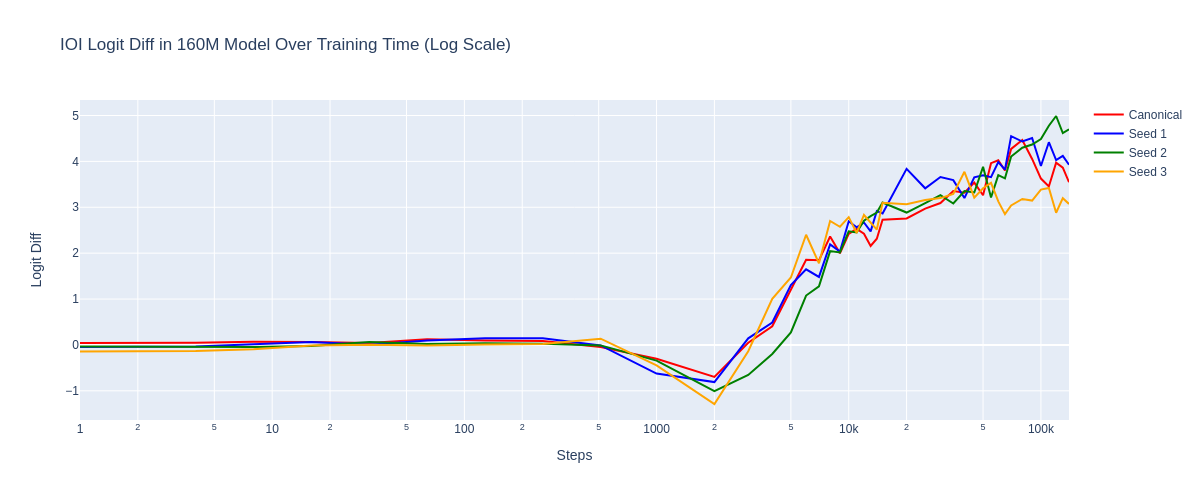

In [ ]:


data_series = [
    metrics['pythia-160m']['ioi']['logit_diff'],
    metrics['pythia-160m-seed1']['ioi']['logit_diff'],
    metrics['pythia-160m-seed2']['ioi']['logit_diff'],
    metrics['pythia-160m-seed3']['ioi']['logit_diff'],
]
labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Logit Diff in 160M Model Over Training Time (Log Scale)')

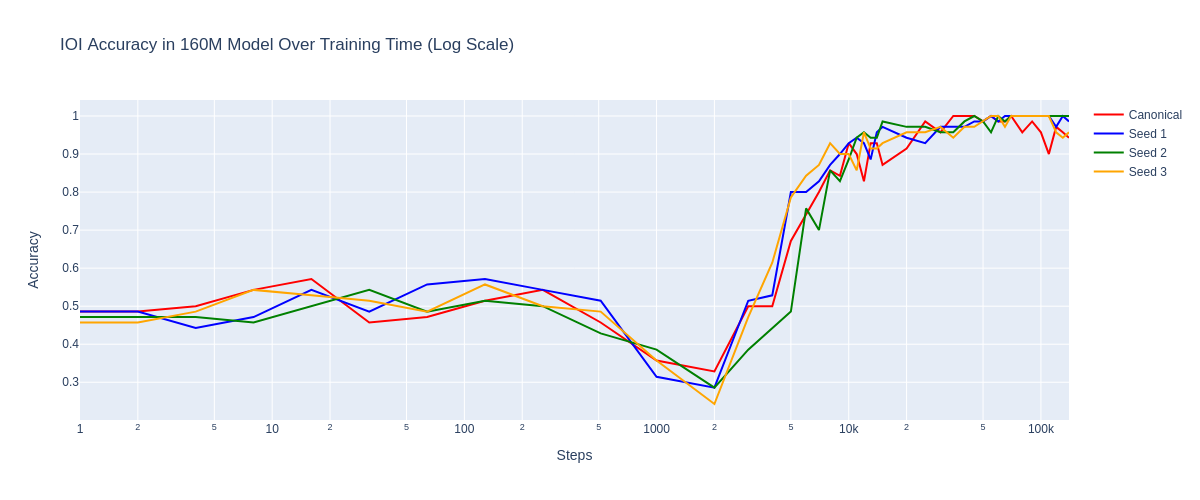

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['accuracy'],
    metrics['pythia-160m-seed1']['ioi']['accuracy'],
    metrics['pythia-160m-seed2']['ioi']['accuracy'],
    metrics['pythia-160m-seed3']['ioi']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='IOI Accuracy in 160M Model Over Training Time (Log Scale)')

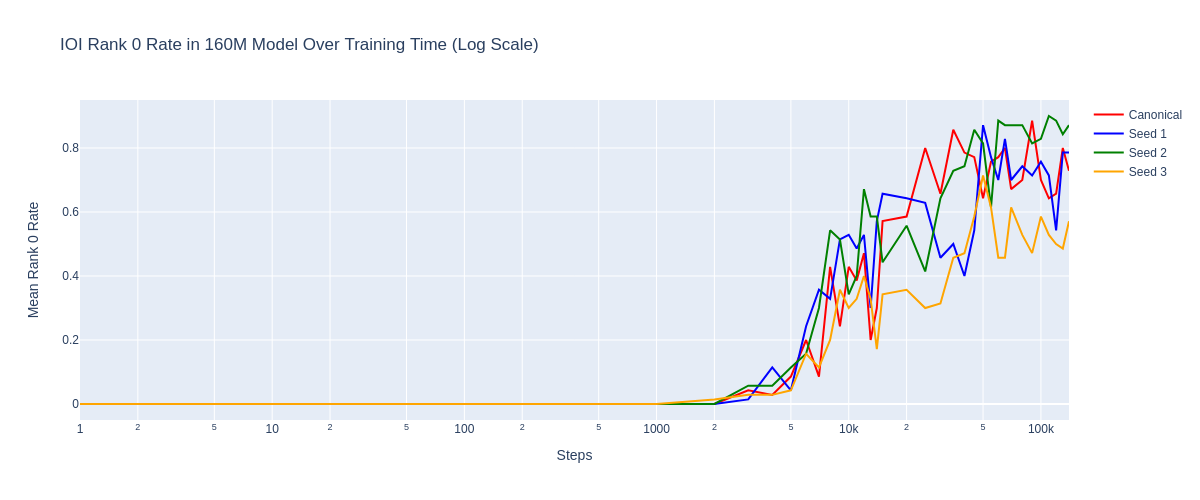

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['rank_0'],
    metrics['pythia-160m-seed1']['ioi']['rank_0'],
    metrics['pythia-160m-seed2']['ioi']['rank_0'],
    metrics['pythia-160m-seed3']['ioi']['rank_0'],

]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Mean Rank 0 Rate', title='IOI Rank 0 Rate in 160M Model Over Training Time (Log Scale)')

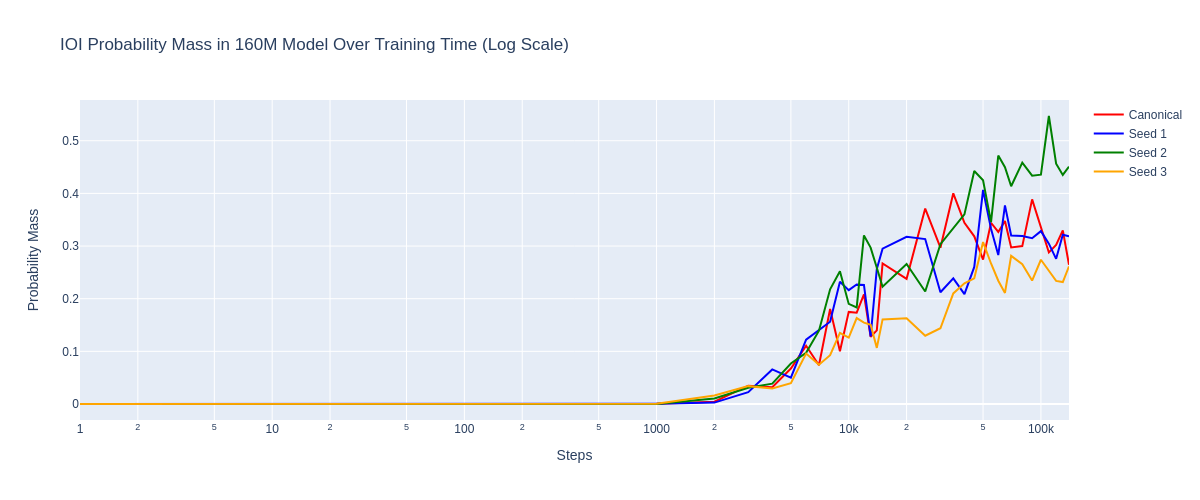

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_mass'],
    metrics['pythia-160m-seed1']['ioi']['probability_mass'],
    metrics['pythia-160m-seed2']['ioi']['probability_mass'],
    metrics['pythia-160m-seed3']['ioi']['probability_mass'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Mass', title='IOI Probability Mass in 160M Model Over Training Time (Log Scale)')

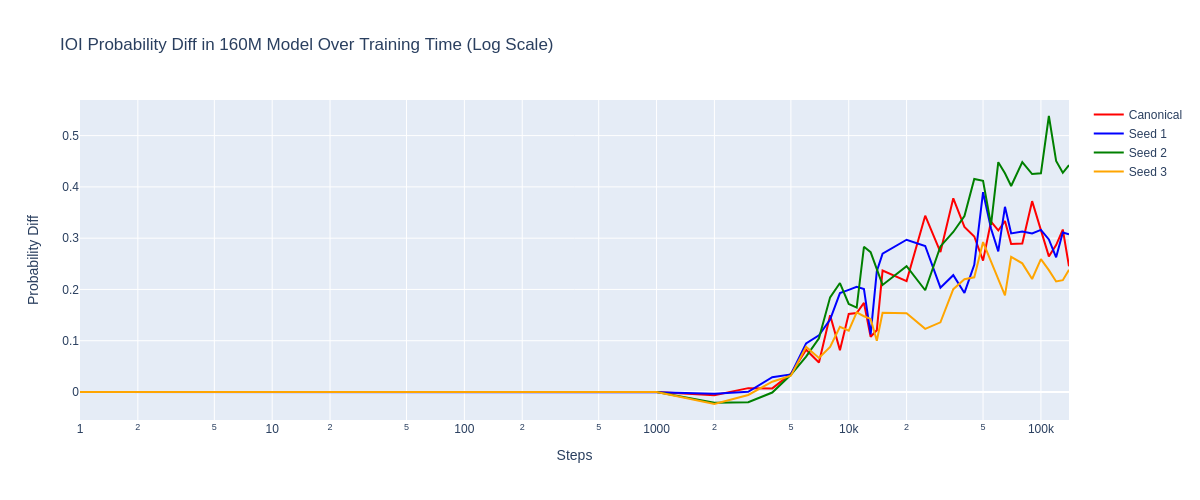

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_diff'],
    metrics['pythia-160m-seed1']['ioi']['probability_diff'],
    metrics['pythia-160m-seed2']['ioi']['probability_diff'],
    metrics['pythia-160m-seed3']['ioi']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='IOI Probability Diff in 160M Model Over Training Time (Log Scale)')

#### Greater-Than

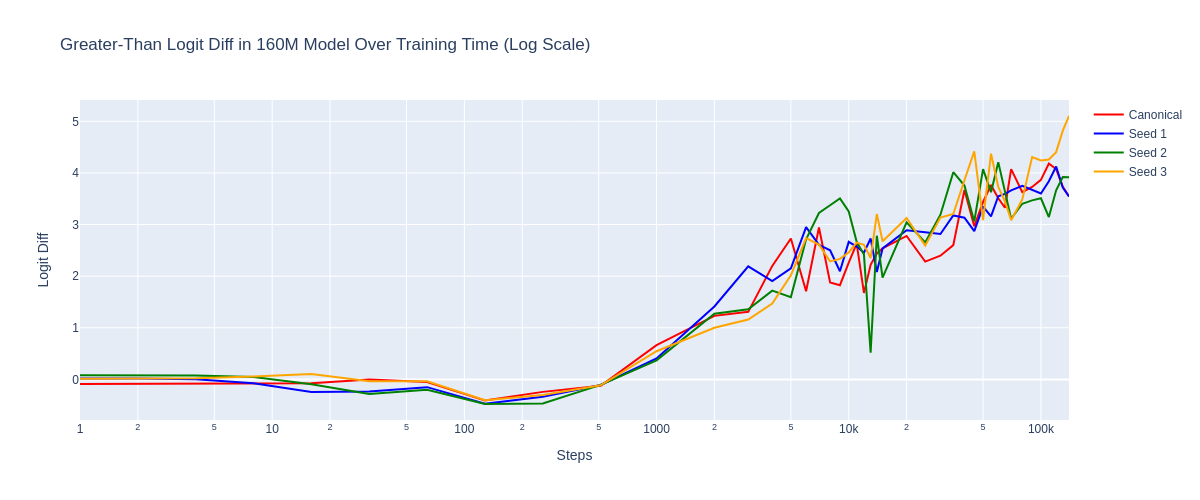

In [ ]:
data_series = [
    metrics['pythia-160m']['greater_than']['logit_diff'],
    metrics['pythia-160m-seed1']['greater_than']['logit_diff'],
    metrics['pythia-160m-seed2']['greater_than']['logit_diff'],
    metrics['pythia-160m-seed3']['greater_than']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Greater-Than Logit Diff in 160M Model Over Training Time (Log Scale)')

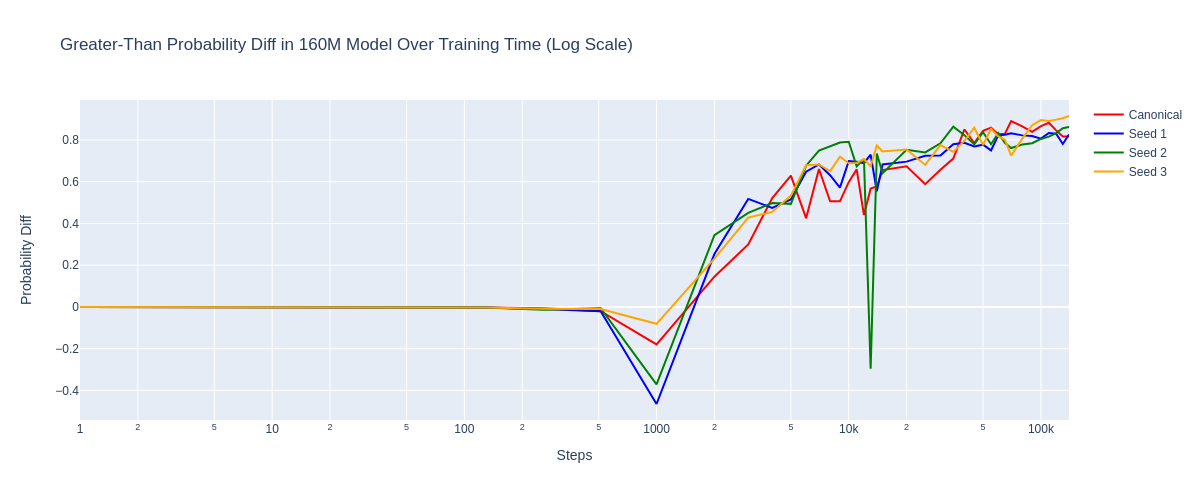

In [ ]:
data_series = [
    metrics['pythia-160m']['greater_than']['prob_diff'],
    metrics['pythia-160m-seed1']['greater_than']['prob_diff'],
    metrics['pythia-160m-seed2']['greater_than']['prob_diff'],
    metrics['pythia-160m-seed3']['greater_than']['prob_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Greater-Than Probability Diff in 160M Model Over Training Time (Log Scale)')

#### Sentiment Completion

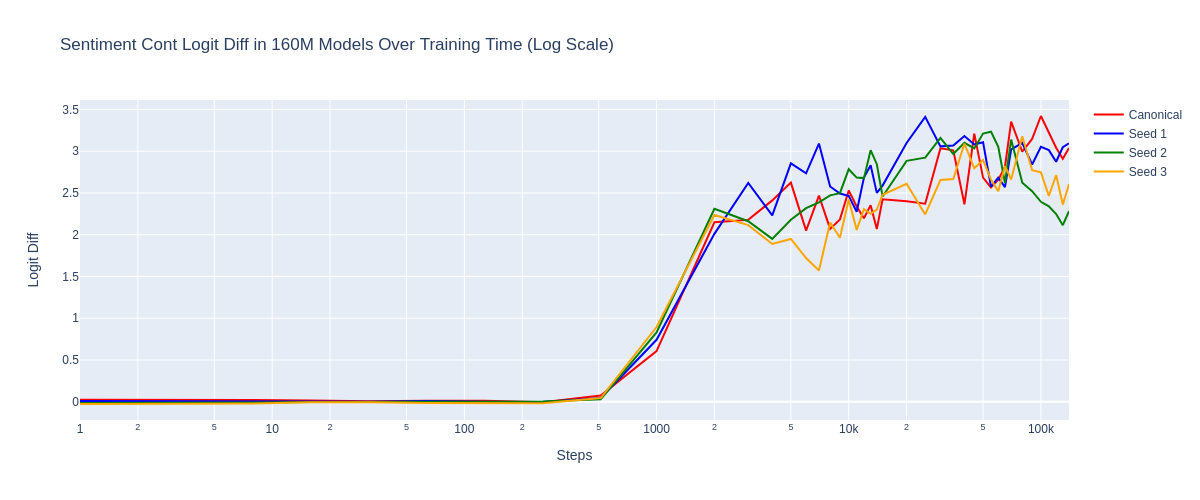

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-seed1']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-seed2']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-seed3']['sentiment_cont']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Cont Logit Diff in 160M Models Over Training Time (Log Scale)')

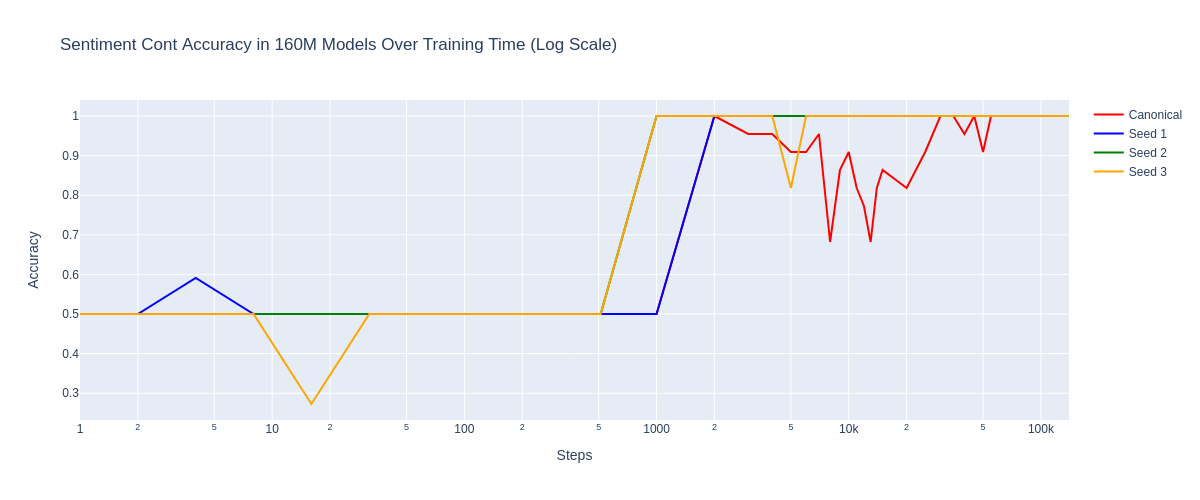

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-seed1']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-seed2']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-seed3']['sentiment_cont']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Cont Accuracy in 160M Models Over Training Time (Log Scale)')

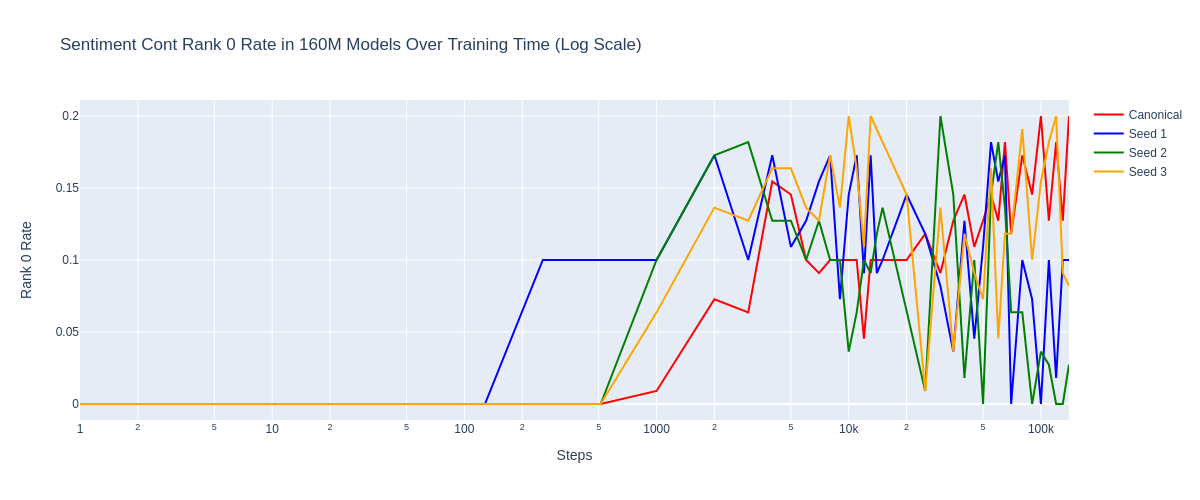

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-seed1']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-seed2']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-seed3']['sentiment_cont']['rank_0'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Cont Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

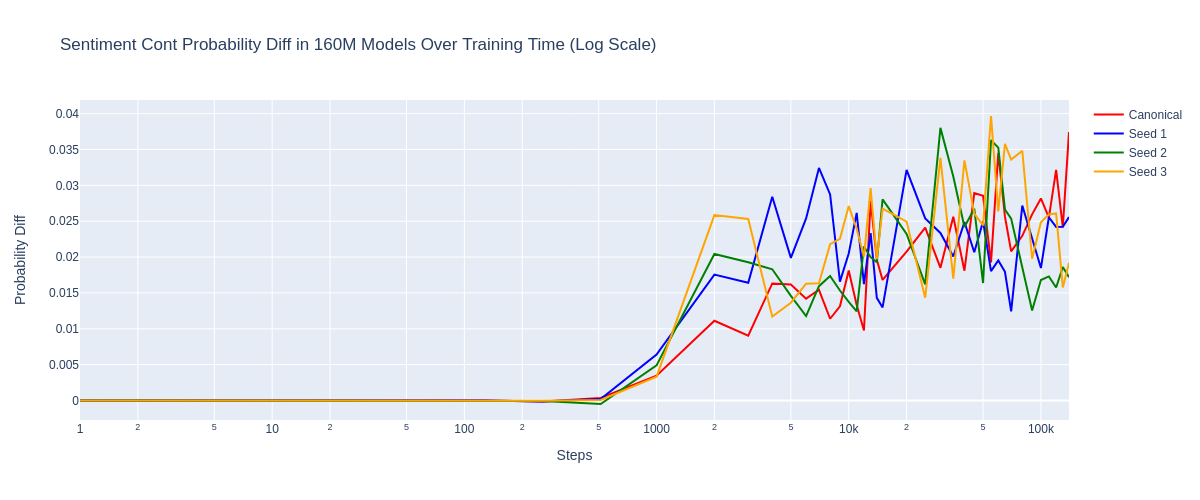

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-seed1']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-seed2']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-seed3']['sentiment_cont']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Cont Probability Diff in 160M Models Over Training Time (Log Scale)')

#### Sentiment Classification

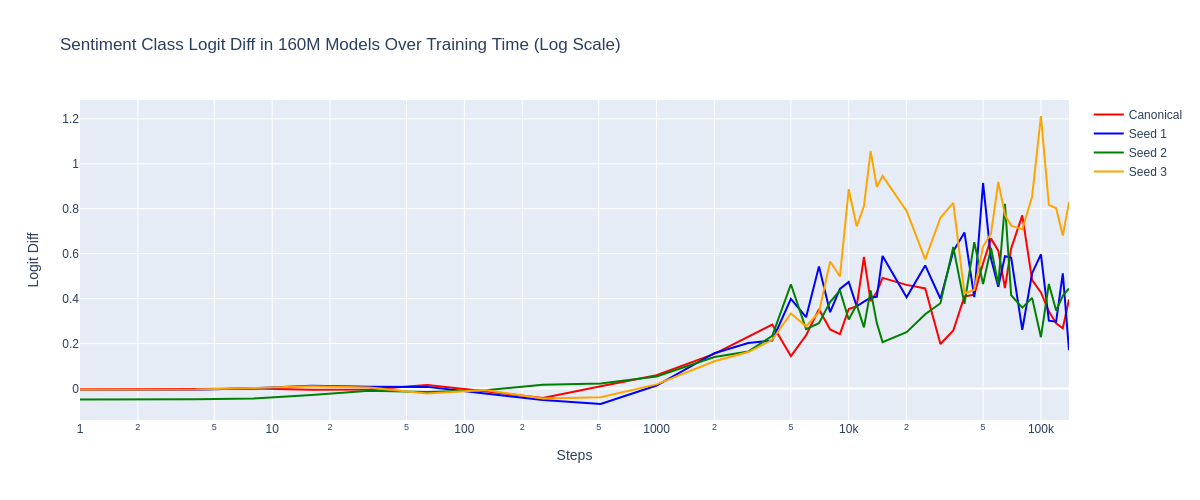

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-seed1']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-seed2']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-seed3']['sentiment_class']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Class Logit Diff in 160M Models Over Training Time (Log Scale)')

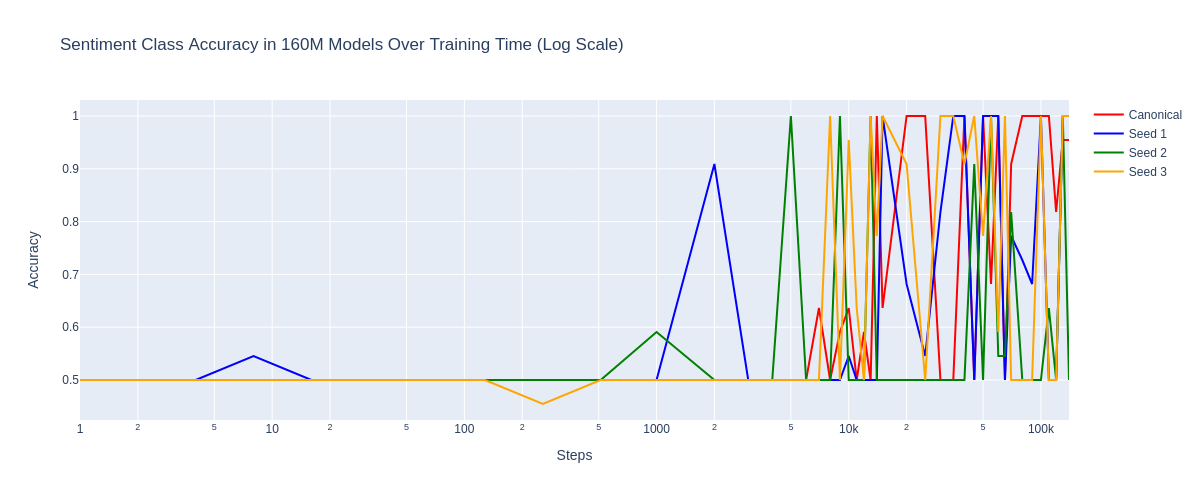

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['accuracy'],
    metrics['pythia-160m-seed1']['sentiment_class']['accuracy'],
    metrics['pythia-160m-seed2']['sentiment_class']['accuracy'],
    metrics['pythia-160m-seed3']['sentiment_class']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3'] 
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Class Accuracy in 160M Models Over Training Time (Log Scale)')

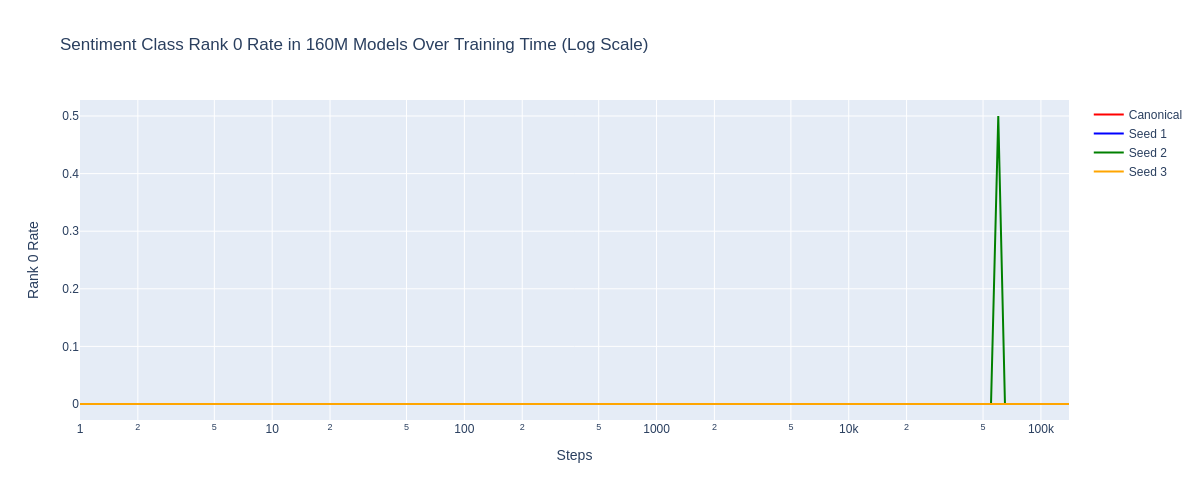

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['rank_0'],
    metrics['pythia-160m-seed1']['sentiment_class']['rank_0'],
    metrics['pythia-160m-seed2']['sentiment_class']['rank_0'],
    metrics['pythia-160m-seed3']['sentiment_class']['rank_0'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Class Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

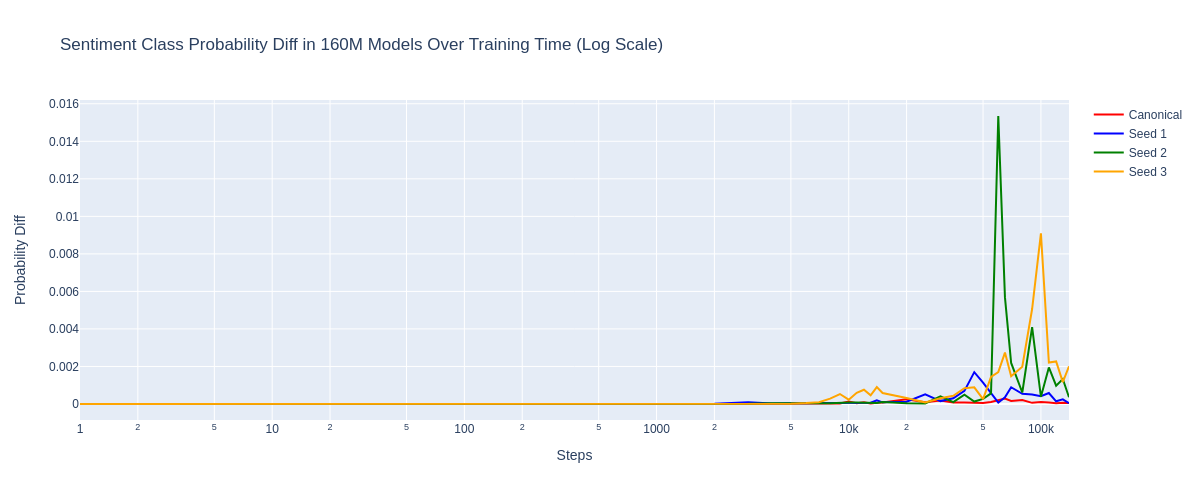

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-seed1']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-seed2']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-seed3']['sentiment_class']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Class Probability Diff in 160M Models Over Training Time (Log Scale)')

### Seeds for Weights Only

#### IOI

In [ ]:
ckpts = get_checkpoint_names("exp_plus_detail")

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['logit_diff'],
    metrics['pythia-160m-weight-seed1']['ioi']['logit_diff'],
    metrics['pythia-160m-weight-seed2']['ioi']['logit_diff'],
    metrics['pythia-160m-weight-seed3']['ioi']['logit_diff'],
]
labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Logit Diff in 160M Model Over Training Time (Log Scale)')

In [ ]:
all_model_weight_seeds_logit_diff = torch.cat(
    (
        metrics['pythia-160m']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed1']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed2']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed3']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:]
    ), dim=0
)
# get the standard deviation of the logit diff
all_model_weight_seeds_logit_diff.std()

tensor(0.4266)

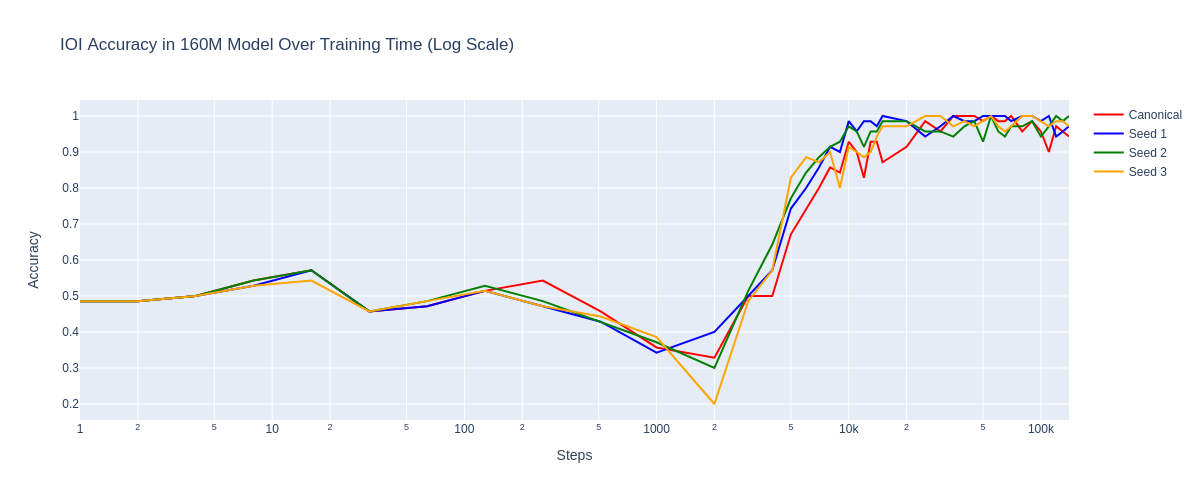

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['accuracy'],
    metrics['pythia-160m-weight-seed1']['ioi']['accuracy'],
    metrics['pythia-160m-weight-seed2']['ioi']['accuracy'],
    metrics['pythia-160m-weight-seed3']['ioi']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='IOI Accuracy in 160M Model Over Training Time (Log Scale)')

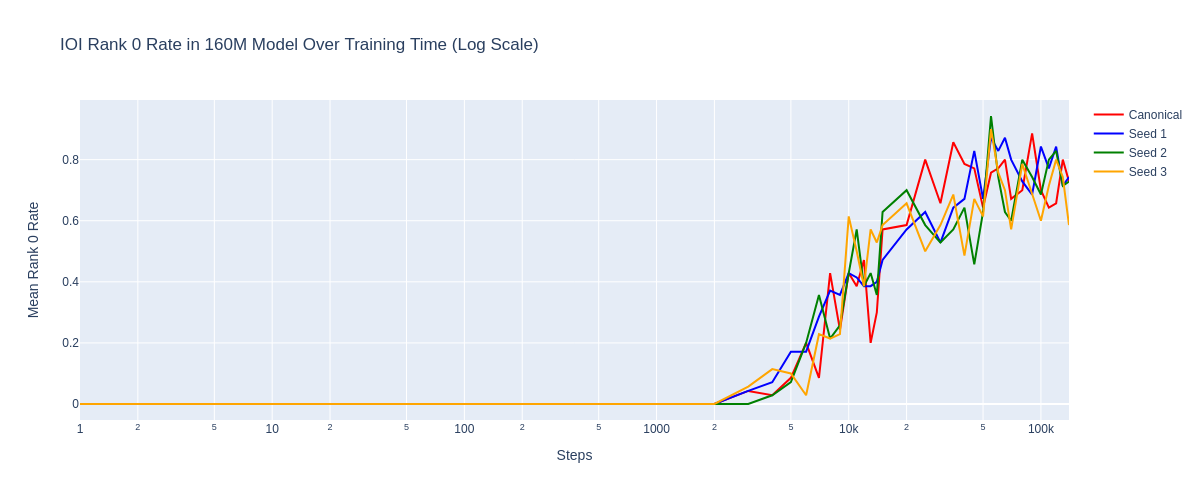

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['rank_0'],
    metrics['pythia-160m-weight-seed1']['ioi']['rank_0'],
    metrics['pythia-160m-weight-seed2']['ioi']['rank_0'],
    metrics['pythia-160m-weight-seed3']['ioi']['rank_0'],

]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Mean Rank 0 Rate', title='IOI Rank 0 Rate in 160M Model Over Training Time (Log Scale)')

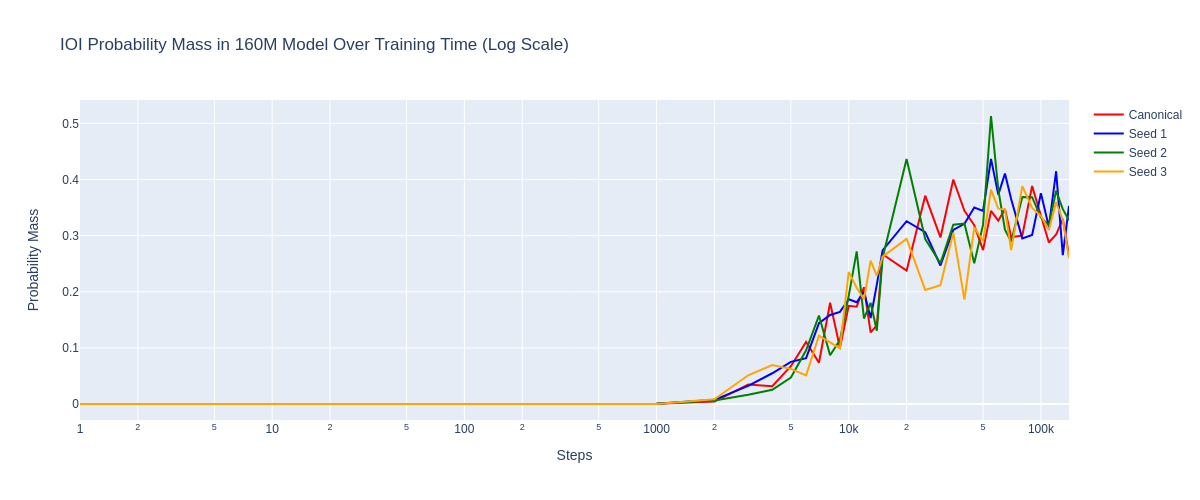

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_mass'],
    metrics['pythia-160m-weight-seed1']['ioi']['probability_mass'],
    metrics['pythia-160m-weight-seed2']['ioi']['probability_mass'],
    metrics['pythia-160m-weight-seed3']['ioi']['probability_mass'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Mass', title='IOI Probability Mass in 160M Model Over Training Time (Log Scale)')

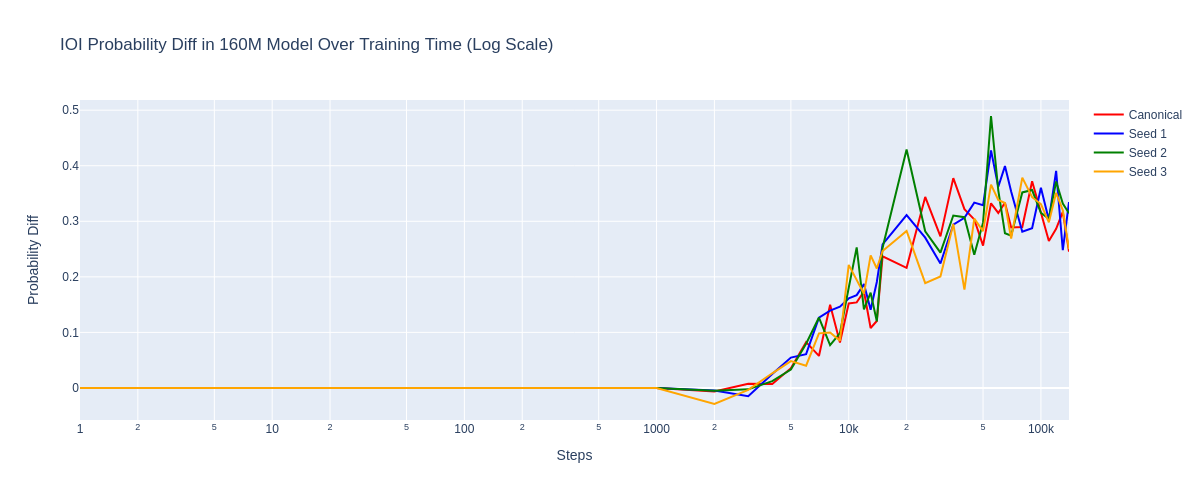

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_diff'],
    metrics['pythia-160m-weight-seed1']['ioi']['probability_diff'],
    metrics['pythia-160m-weight-seed2']['ioi']['probability_diff'],
    metrics['pythia-160m-weight-seed3']['ioi']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='IOI Probability Diff in 160M Model Over Training Time (Log Scale)')

In [ ]:
all_model_weight_seeds_prob_diff = torch.cat(
    (
        metrics['pythia-160m']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed1']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed2']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed3']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:]
    ), dim=0
)
# get the standard deviation of the probability diff
all_model_weight_seeds_prob_diff.std()

tensor(0.0401)

#### Greater-Than

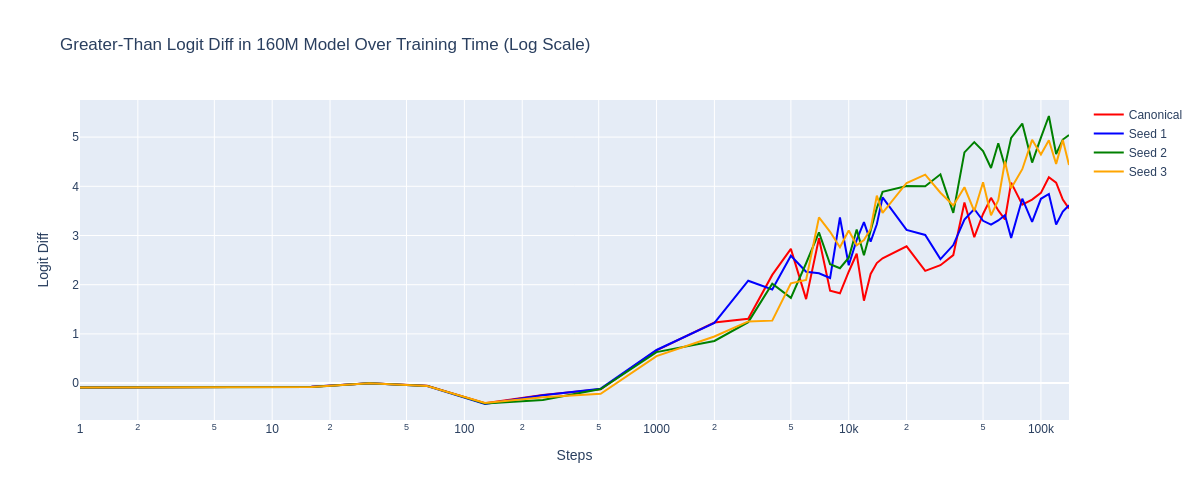

In [ ]:
data_series = [
    metrics['pythia-160m']['greater_than']['logit_diff'],
    metrics['pythia-160m-weight-seed1']['greater_than']['logit_diff'],
    metrics['pythia-160m-weight-seed2']['greater_than']['logit_diff'],
    metrics['pythia-160m-weight-seed3']['greater_than']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Greater-Than Logit Diff in 160M Model Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-160m']['greater_than']['prob_diff'],
    metrics['pythia-160m-weight-seed1']['greater_than']['prob_diff'],
    metrics['pythia-160m-weight-seed2']['greater_than']['prob_diff'],
    metrics['pythia-160m-weight-seed3']['greater_than']['prob_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Greater-Than Probability Diff in 160M Model Over Training Time (Log Scale)')

In [ ]:
all_model_weight_seeds_prob_diff = torch.cat(
    (
        metrics['pythia-160m']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed1']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed2']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:], 
        metrics['pythia-160m-weight-seed3']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:]
    ), dim=0
)
# get the standard deviation of the probability diff
all_model_weight_seeds_prob_diff.std()

tensor(0.0484)

#### Sentiment Completion

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-weight-seed1']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-weight-seed2']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-weight-seed3']['sentiment_cont']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Cont Logit Diff in 160M Models Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-weight-seed1']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-weight-seed2']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-weight-seed3']['sentiment_cont']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Cont Accuracy in 160M Models Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-weight-seed1']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-weight-seed2']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-weight-seed3']['sentiment_cont']['rank_0'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Cont Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-weight-seed1']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-weight-seed2']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-weight-seed3']['sentiment_cont']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Cont Probability Diff in 160M Models Over Training Time (Log Scale)')

#### Sentiment Classification

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-weight-seed1']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-weight-seed2']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-weight-seed3']['sentiment_class']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Class Logit Diff in 160M Models Over Training Time (Log Scale)')

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['accuracy'],
    metrics['pythia-160m-weight-seed1']['sentiment_class']['accuracy'],
    metrics['pythia-160m-weight-seed2']['sentiment_class']['accuracy'],
    metrics['pythia-160m-weight-seed3']['sentiment_class']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3'] 
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Class Accuracy in 160M Models Over Training Time (Log Scale)')

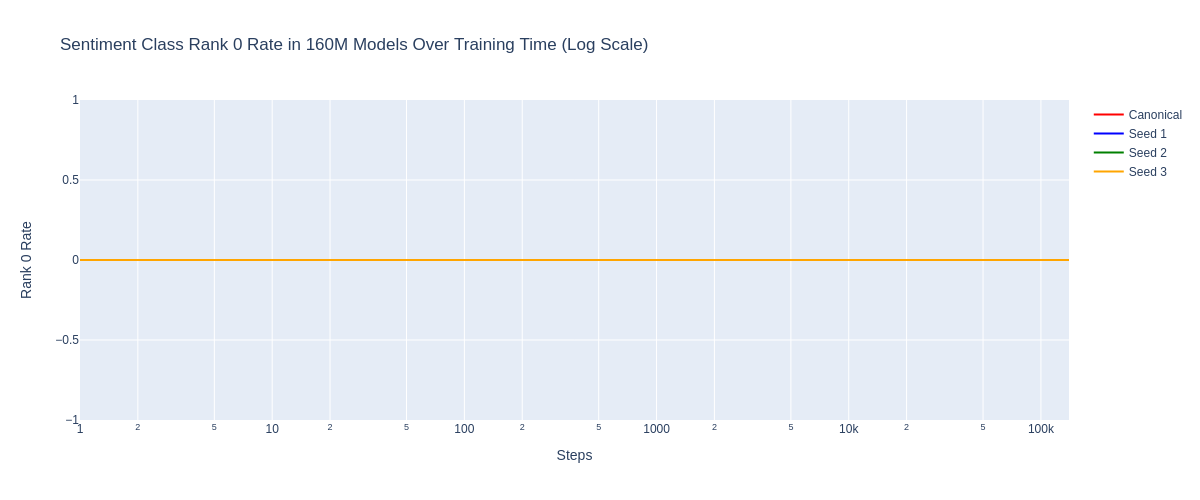

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['rank_0'],
    metrics['pythia-160m-weight-seed1']['sentiment_class']['rank_0'],
    metrics['pythia-160m-weight-seed2']['sentiment_class']['rank_0'],
    metrics['pythia-160m-weight-seed3']['sentiment_class']['rank_0'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Class Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

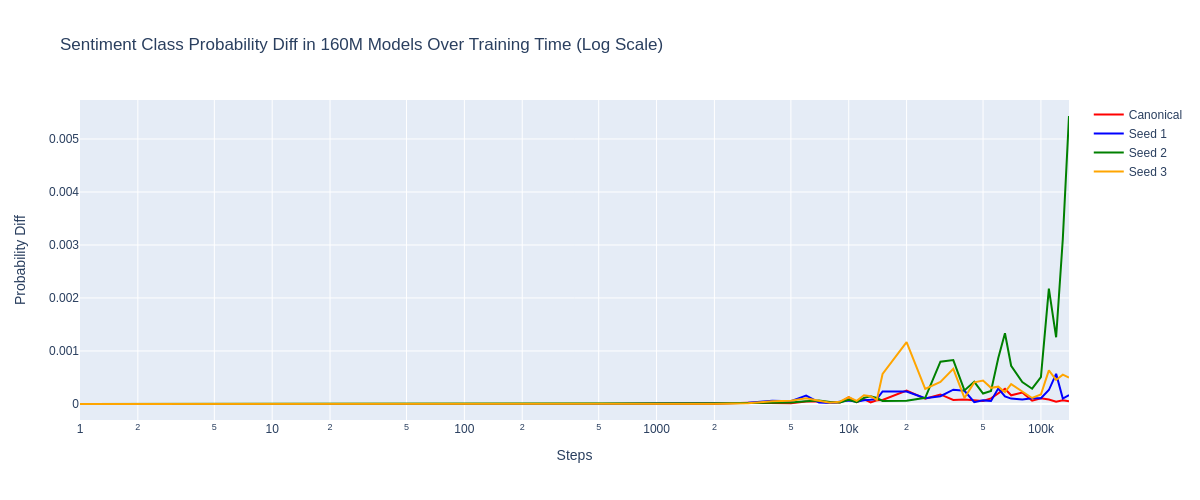

In [ ]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-weight-seed1']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-weight-seed2']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-weight-seed3']['sentiment_class']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Class Probability Diff in 160M Models Over Training Time (Log Scale)')

### Seeds for Data Only

In [ ]:
ckpts = get_checkpoint_names("exp_plus_detail")

#### IOI

In [ ]:


data_series = [
    metrics['pythia-160m']['ioi']['logit_diff'],
    metrics['pythia-160m-data-seed1']['ioi']['logit_diff'],
    metrics['pythia-160m-data-seed2']['ioi']['logit_diff'],
    metrics['pythia-160m-data-seed3']['ioi']['logit_diff'],
]
labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='IOI Logit Diff in 160M Models Over Training Time (Log Scale)')

In [ ]:
all_model_data_seeds_logit_diff = torch.cat(
    (
        metrics['pythia-160m']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed1']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed2']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed3']['ioi']['logit_diff'][ST_DEV_SAMPLE_IDX:],
    ), dim=0
)
# get the standard deviation of the logit diff
all_model_data_seeds_logit_diff.std()

tensor(0.3785)

In [ ]:
data_series = [
    metrics['pythia-160m']['ioi']['accuracy'],
    metrics['pythia-160m-data-seed1']['ioi']['accuracy'],
    metrics['pythia-160m-data-seed2']['ioi']['accuracy'],
    metrics['pythia-160m-data-seed3']['ioi']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='IOI Accuracy in 160M Models Over Training Time (Log Scale)')

NameError: name 'ckpts' is not defined

In [11]:
data_series = [
    metrics['pythia-160m']['ioi']['rank_0'],
    metrics['pythia-160m-data-seed1']['ioi']['rank_0'],
    metrics['pythia-160m-data-seed2']['ioi']['rank_0'],
    metrics['pythia-160m-data-seed3']['ioi']['rank_0'],

]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Mean Rank 0 Rate', title='IOI Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

NameError: name 'ckpts' is not defined

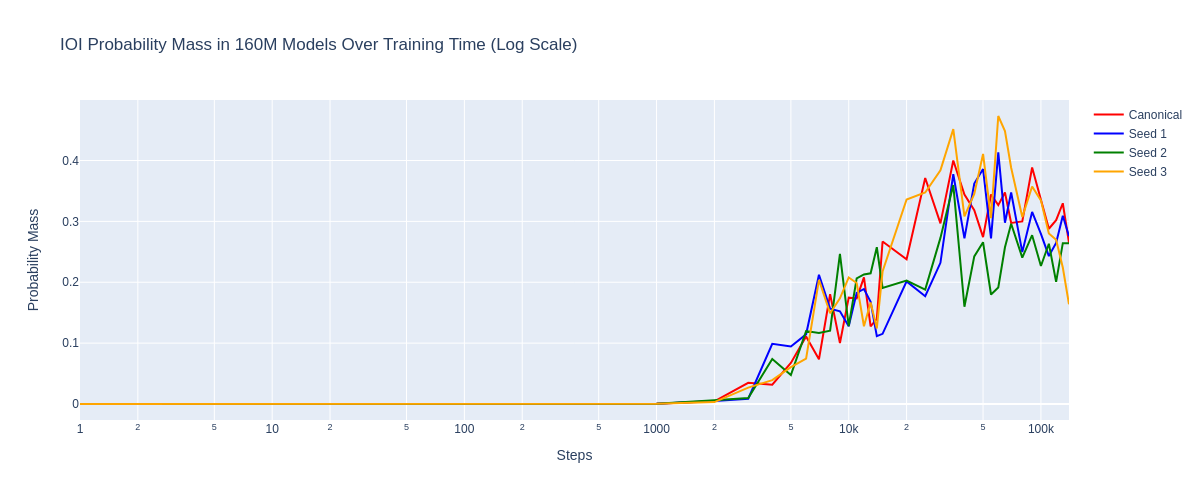

In [142]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_mass'],
    metrics['pythia-160m-data-seed1']['ioi']['probability_mass'],
    metrics['pythia-160m-data-seed2']['ioi']['probability_mass'],
    metrics['pythia-160m-data-seed3']['ioi']['probability_mass'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Mass', title='IOI Probability Mass in 160M Models Over Training Time (Log Scale)')

In [248]:
data_series = [
    metrics['pythia-160m']['ioi']['probability_diff'],
    metrics['pythia-160m-data-seed1']['ioi']['probability_diff'],
    metrics['pythia-160m-data-seed2']['ioi']['probability_diff'],
    metrics['pythia-160m-data-seed3']['ioi']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='IOI Probability Diff in 160M Models Over Training Time (Log Scale)')

In [249]:
all_model_data_seeds_prob_diff = torch.cat(
    (
        metrics['pythia-160m']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed1']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed2']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed3']['ioi']['probability_diff'][ST_DEV_SAMPLE_IDX:],
    ), dim=0
)

all_model_data_seeds_prob_diff.std()

tensor(0.0645)

#### Greater-Than

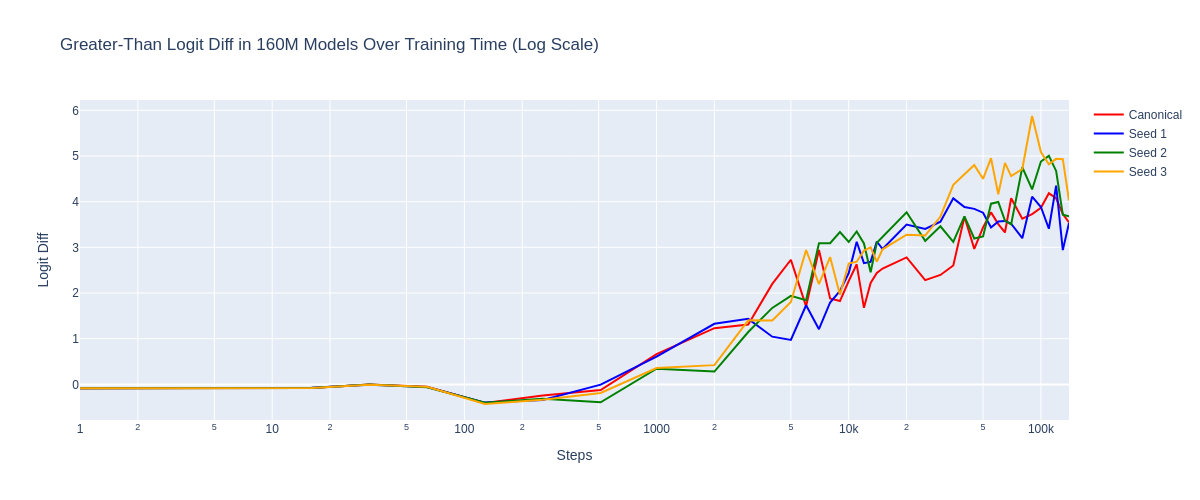

In [144]:
data_series = [
    metrics['pythia-160m']['greater_than']['logit_diff'],
    metrics['pythia-160m-data-seed1']['greater_than']['logit_diff'],
    metrics['pythia-160m-data-seed2']['greater_than']['logit_diff'],
    metrics['pythia-160m-data-seed3']['greater_than']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Greater-Than Logit Diff in 160M Models Over Training Time (Log Scale)')

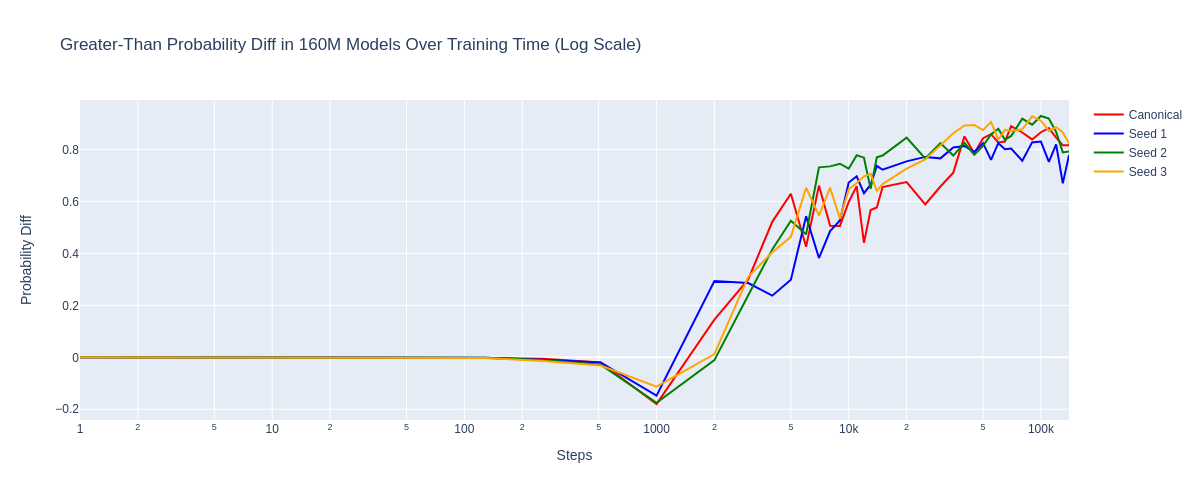

In [145]:
data_series = [
    metrics['pythia-160m']['greater_than']['prob_diff'],
    metrics['pythia-160m-data-seed1']['greater_than']['prob_diff'],
    metrics['pythia-160m-data-seed2']['greater_than']['prob_diff'],
    metrics['pythia-160m-data-seed3']['greater_than']['prob_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Greater-Than Probability Diff in 160M Models Over Training Time (Log Scale)')

In [259]:
all_model_data_seeds_gt_prob_diff = torch.cat(
    (
        metrics['pythia-160m']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed1']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed2']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed3']['greater_than']['prob_diff'][ST_DEV_SAMPLE_IDX:],
    ), dim=0
)

all_model_data_seeds_gt_prob_diff.std()

tensor(0.0528)

#### Sentiment Completion

In [269]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-data-seed1']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-data-seed2']['sentiment_cont']['logit_diff'],
    metrics['pythia-160m-data-seed3']['sentiment_cont']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Cont Logit Diff in 160M Models Over Training Time (Log Scale)')

In [270]:
all_model_data_seeds_sc_logit_diff = torch.cat(
    (
        metrics['pythia-160m']['sentiment_cont']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed1']['sentiment_cont']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed2']['sentiment_cont']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed3']['sentiment_cont']['logit_diff'][ST_DEV_SAMPLE_IDX:],
    ), dim=0
)

all_model_data_seeds_sc_logit_diff.std()

tensor(0.4720)

In [271]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-data-seed1']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-data-seed2']['sentiment_cont']['accuracy'],
    metrics['pythia-160m-data-seed3']['sentiment_cont']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Cont Accuracy in 160M Models Over Training Time (Log Scale)')

In [272]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-data-seed1']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-data-seed2']['sentiment_cont']['rank_0'],
    metrics['pythia-160m-data-seed3']['sentiment_cont']['rank_0'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Cont Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

In [273]:
data_series = [
    metrics['pythia-160m']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-data-seed1']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-data-seed2']['sentiment_cont']['probability_diff'],
    metrics['pythia-160m-data-seed3']['sentiment_cont']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']
plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Cont Probability Diff in 160M Models Over Training Time (Log Scale)')

#### Sentiment Classification

In [274]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-data-seed1']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-data-seed2']['sentiment_class']['logit_diff'],
    metrics['pythia-160m-data-seed3']['sentiment_class']['logit_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Logit Diff', title='Sentiment Class Logit Diff in 160M Models Over Training Time (Log Scale)')

In [275]:
all_model_data_seeds_scl_logit_diff = torch.cat(
    (
        metrics['pythia-160m']['sentiment_class']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed1']['sentiment_class']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed2']['sentiment_class']['logit_diff'][ST_DEV_SAMPLE_IDX:],
        metrics['pythia-160m-data-seed3']['sentiment_class']['logit_diff'][ST_DEV_SAMPLE_IDX:],
    ), dim=0
)

all_model_data_seeds_scl_logit_diff.std()

tensor(0.2281)

In [276]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['accuracy'],
    metrics['pythia-160m-data-seed1']['sentiment_class']['accuracy'],
    metrics['pythia-160m-data-seed2']['sentiment_class']['accuracy'],
    metrics['pythia-160m-data-seed3']['sentiment_class']['accuracy'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3'] 
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Accuracy', title='Sentiment Class Accuracy in 160M Models Over Training Time (Log Scale)')

In [277]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['rank_0'],
    metrics['pythia-160m-data-seed1']['sentiment_class']['rank_0'],
    metrics['pythia-160m-data-seed2']['sentiment_class']['rank_0'],
    metrics['pythia-160m-data-seed3']['sentiment_class']['rank_0'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Rank 0 Rate', title='Sentiment Class Rank 0 Rate in 160M Models Over Training Time (Log Scale)')

In [278]:
data_series = [
    metrics['pythia-160m']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-data-seed1']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-data-seed2']['sentiment_class']['probability_diff'],
    metrics['pythia-160m-data-seed3']['sentiment_class']['probability_diff'],
]

labels = ['Canonical', 'Seed 1', 'Seed 2', 'Seed 3']
colors = ['red', 'blue', 'green', 'orange']

plot_lines(data_series, labels, colors, x_vals=ckpts, x_title='Steps', y_title='Probability Diff', title='Sentiment Class Probability Diff in 160M Models Over Training Time (Log Scale)')